In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from tqdm import tqdm
import seaborn as snb
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from utils.tools import *

In [2]:
import argparse
sys.argv = ['structure.py']
parser = argparse.ArgumentParser()
parser.add_argument('--Dim', type=int, default=3)
parser.add_argument('--Nodes_num', type=int, default=20)
parser.add_argument('--dt', type=float, default=0.01)
parser.add_argument('--Net', type=str, default='ER', help='BA, Di_BA or ER')
parser.add_argument('--Model', type=str, default='HR', help='Attractor')
parser.add_argument('--Time', type=int, default=500, help='T_time, default=10')
parser.add_argument('--Batch', type=int, default=256, help='BatchSize, default=4096')
parser.add_argument('--Hidden', type=int, default=50, help='Hidden Neurons')

args, unknown = parser.parse_known_args()

lam = None
tau_up = 0.999

In [3]:
data_path = 'data/'
save_path = 'Training_process/'

In [4]:
from utils.model import *
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
nodes_num = args.Nodes_num

aggr = 'add'
model = 'HR'
hidden = args.Hidden
n_f = 3
dt = args.dt
msg_dim = 1
dim = args.Dim

In [5]:
path = data_path+'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)
with open(save_path+'weights_tau0.999_lam0.0001_20251013_191841.pkl', 'rb') as f:
    weights_over_epcs = pickle.load(f)

epc = 1999
weights_ind = weights_over_epcs[epc]
weights_ind = torch.Tensor(weights_ind)

In [6]:
len(np.where(objectAij==-1)[0]) # true inhibitory edges

58

In [7]:
len(np.where(objectAij==1)[0]) # true excitatory edges

42

In [8]:
import torch
import torch.nn.functional as F
    
nodes_num = args.Nodes_num
Accuracy = []
threshold = 0.5

def get_binary_weight_error(weights_over_epcs,threshold):
    for w in range(len(weights_over_epcs)):
        weights_ind = weights_over_epcs[w]
        weights_ind = torch.Tensor(weights_ind)
        Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
        Gweights = ((-1)*Gweights[:,0]+Gweights[:,1])
        Gweights = Gweights.view(-1,1).cpu()
        bestWei = Gweights.detach().numpy()
        
        bi_bestWei = bestWei.copy()
        bi_bestWei = np.where(bi_bestWei<-0.5,-1,bi_bestWei)
        bi_bestWei = np.where(bi_bestWei>0.5,1,bi_bestWei)
        bi_bestWei = np.where((bi_bestWei>-0.5) & (bi_bestWei<0.5),0,bi_bestWei)

        bi_Stru = np.zeros((nodes_num, nodes_num))
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        bi_Stru[mask] = bi_bestWei.squeeze()

        bi_bestWei_alllinks = bi_Stru.reshape(-1,1)
        error = np.sum(np.abs(bi_bestWei_alllinks - objectAij.reshape(-1,1)))/(nodes_num*(nodes_num-1))
        Accuracy.append(1-error)
    return Accuracy

Accu = get_binary_weight_error(weights_over_epcs,0.5)

triple classificatio: calculate precision and recall value for each class, then calculate $f1-score=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$

In [9]:
from sklearn.metrics import f1_score
inhedge = []
exiedge = []
noedge = []

def get_weight_f1score(weights_over_epcs,threshold):
    for w in range(len(weights_over_epcs)):
        weights_ind = weights_over_epcs[w]
        weights_ind = torch.Tensor(weights_ind)
        Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
        Gweights = ((-1)*Gweights[:,0]+Gweights[:,1])
        Gweights = Gweights.view(-1,1).cpu()
        bestWei = Gweights.detach().numpy()
        
        bi_bestWei = bestWei.copy()
        bi_bestWei = np.where(bi_bestWei<-threshold,-1,bi_bestWei)
        bi_bestWei = np.where(bi_bestWei>threshold,1,bi_bestWei)
        bi_bestWei = np.where((bi_bestWei>-threshold) & (bi_bestWei<threshold),0,bi_bestWei)

        bi_Stru = np.zeros((nodes_num, nodes_num))
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        bi_Stru[mask] = bi_bestWei.squeeze()

        bi_bestWei_alllinks = bi_Stru.reshape(-1,1)
        nscore, zscore, pscore = f1_score(objectAij.reshape(-1,1), bi_bestWei_alllinks, average=None)
        # nscore, zscore, pscore = f1_score(objectAij.reshape(-1,1), -bi_bestWei_alllinks, average=None) # if the inferred edge sign is reversed
        inhedge.append(nscore)
        noedge.append(zscore)
        exiedge.append(pscore)
    return inhedge, noedge, exiedge
inhedge, noedge, exiedge = get_weight_f1score(weights_over_epcs,0.5)

(2000, 3)


/tmp/ipykernel_15467/1246450518.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Evaluation['epoch'] = np.arange(1, len(Evaluation)+1)
/tmp/ipykernel_15467/1246450518.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Evaluation['x_bin'] = pd.cut(Evaluation['epoch'], bins=25)
/tmp/ipykernel_15467/1246450518.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt

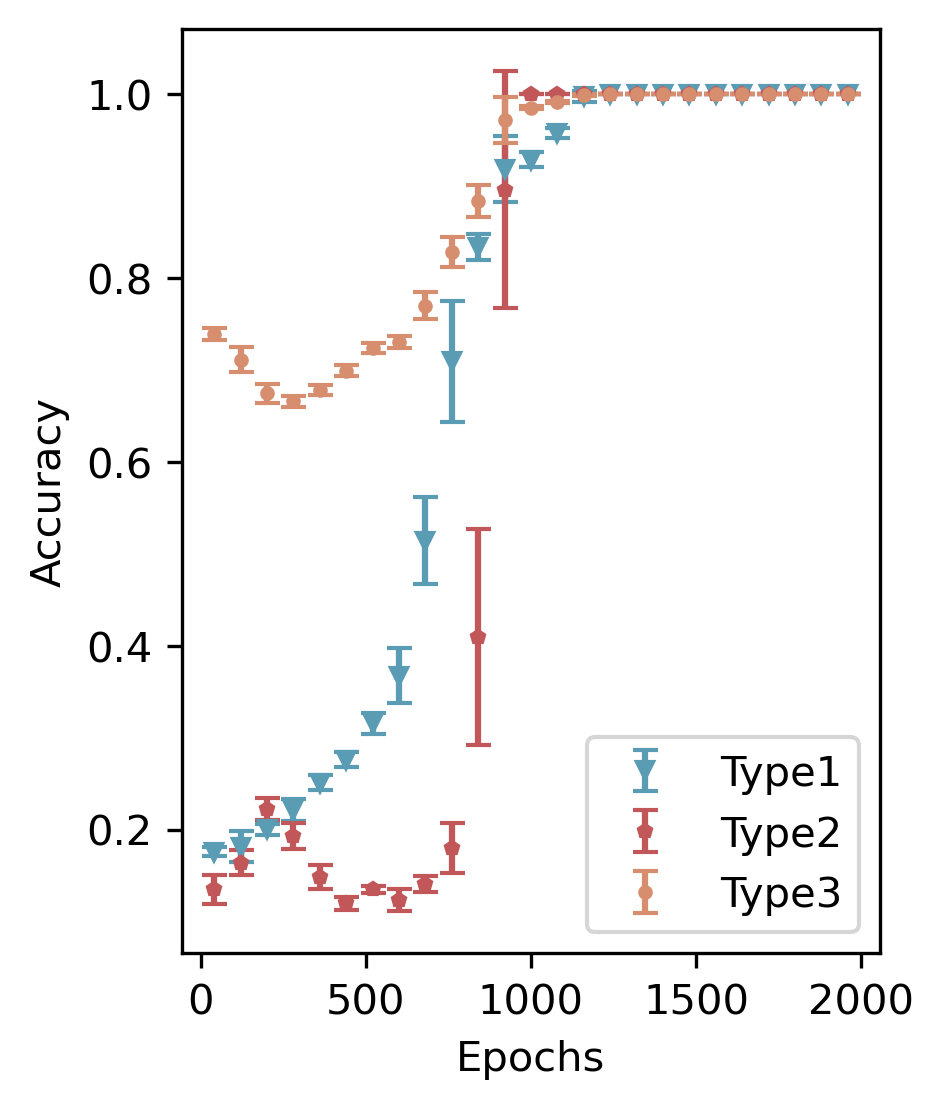

In [10]:
import matplotlib.pyplot as plt
import numpy as np

Eval = pd.DataFrame()   
Eval['inhedge_accu'] = inhedge
Eval['noedge_accu'] = noedge
Eval['exiedge_accu'] = exiedge
print(Eval.shape)
Evaluation = Eval[0:2000]
Evaluation['epoch'] = np.arange(1, len(Evaluation)+1)
Evaluation['x_bin'] = pd.cut(Evaluation['epoch'], bins=25)

inhedge_stats = Evaluation.groupby('x_bin')['inhedge_accu'].agg(['mean', 'std'])
inhedge_centers = inhedge_stats.index.map(lambda x: x.mid).astype(float)
exiedge_stats = Evaluation.groupby('x_bin')['exiedge_accu'].agg(['mean', 'std'])
exiedge_centers = exiedge_stats.index.map(lambda x: x.mid).astype(float)
noedge_stats = Evaluation.groupby('x_bin')['noedge_accu'].agg(['mean', 'std'])
noedge_centers = noedge_stats.index.map(lambda x: x.mid).astype(float)

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(3,4))

# palette = ['#C25759','#599CB4']
plt.errorbar(x=inhedge_centers, y=inhedge_stats['mean'], yerr=inhedge_stats['std'], fmt='v', capsize=3,markersize=4,label='Type1',color='#599CB4')
plt.errorbar(x=exiedge_centers, y=exiedge_stats['mean'], yerr=exiedge_stats['std'], fmt='p', capsize=3,markersize=3,label='Type2',color='#C25759')
plt.errorbar(x=noedge_centers, y=noedge_stats['mean'], yerr=noedge_stats['std'], fmt='o', capsize=3,markersize=2.5,label='Type3',color='#D78E6E')
plt.legend(facecolor='white',loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.grid(axis='y',ls='--',color='lightgray', alpha=0.6)
# plt.savefig('figure2/v6/Accuracy_over_epoch_red_green.pdf')
plt.show()

### read weights results no comparison (did not identify each type)

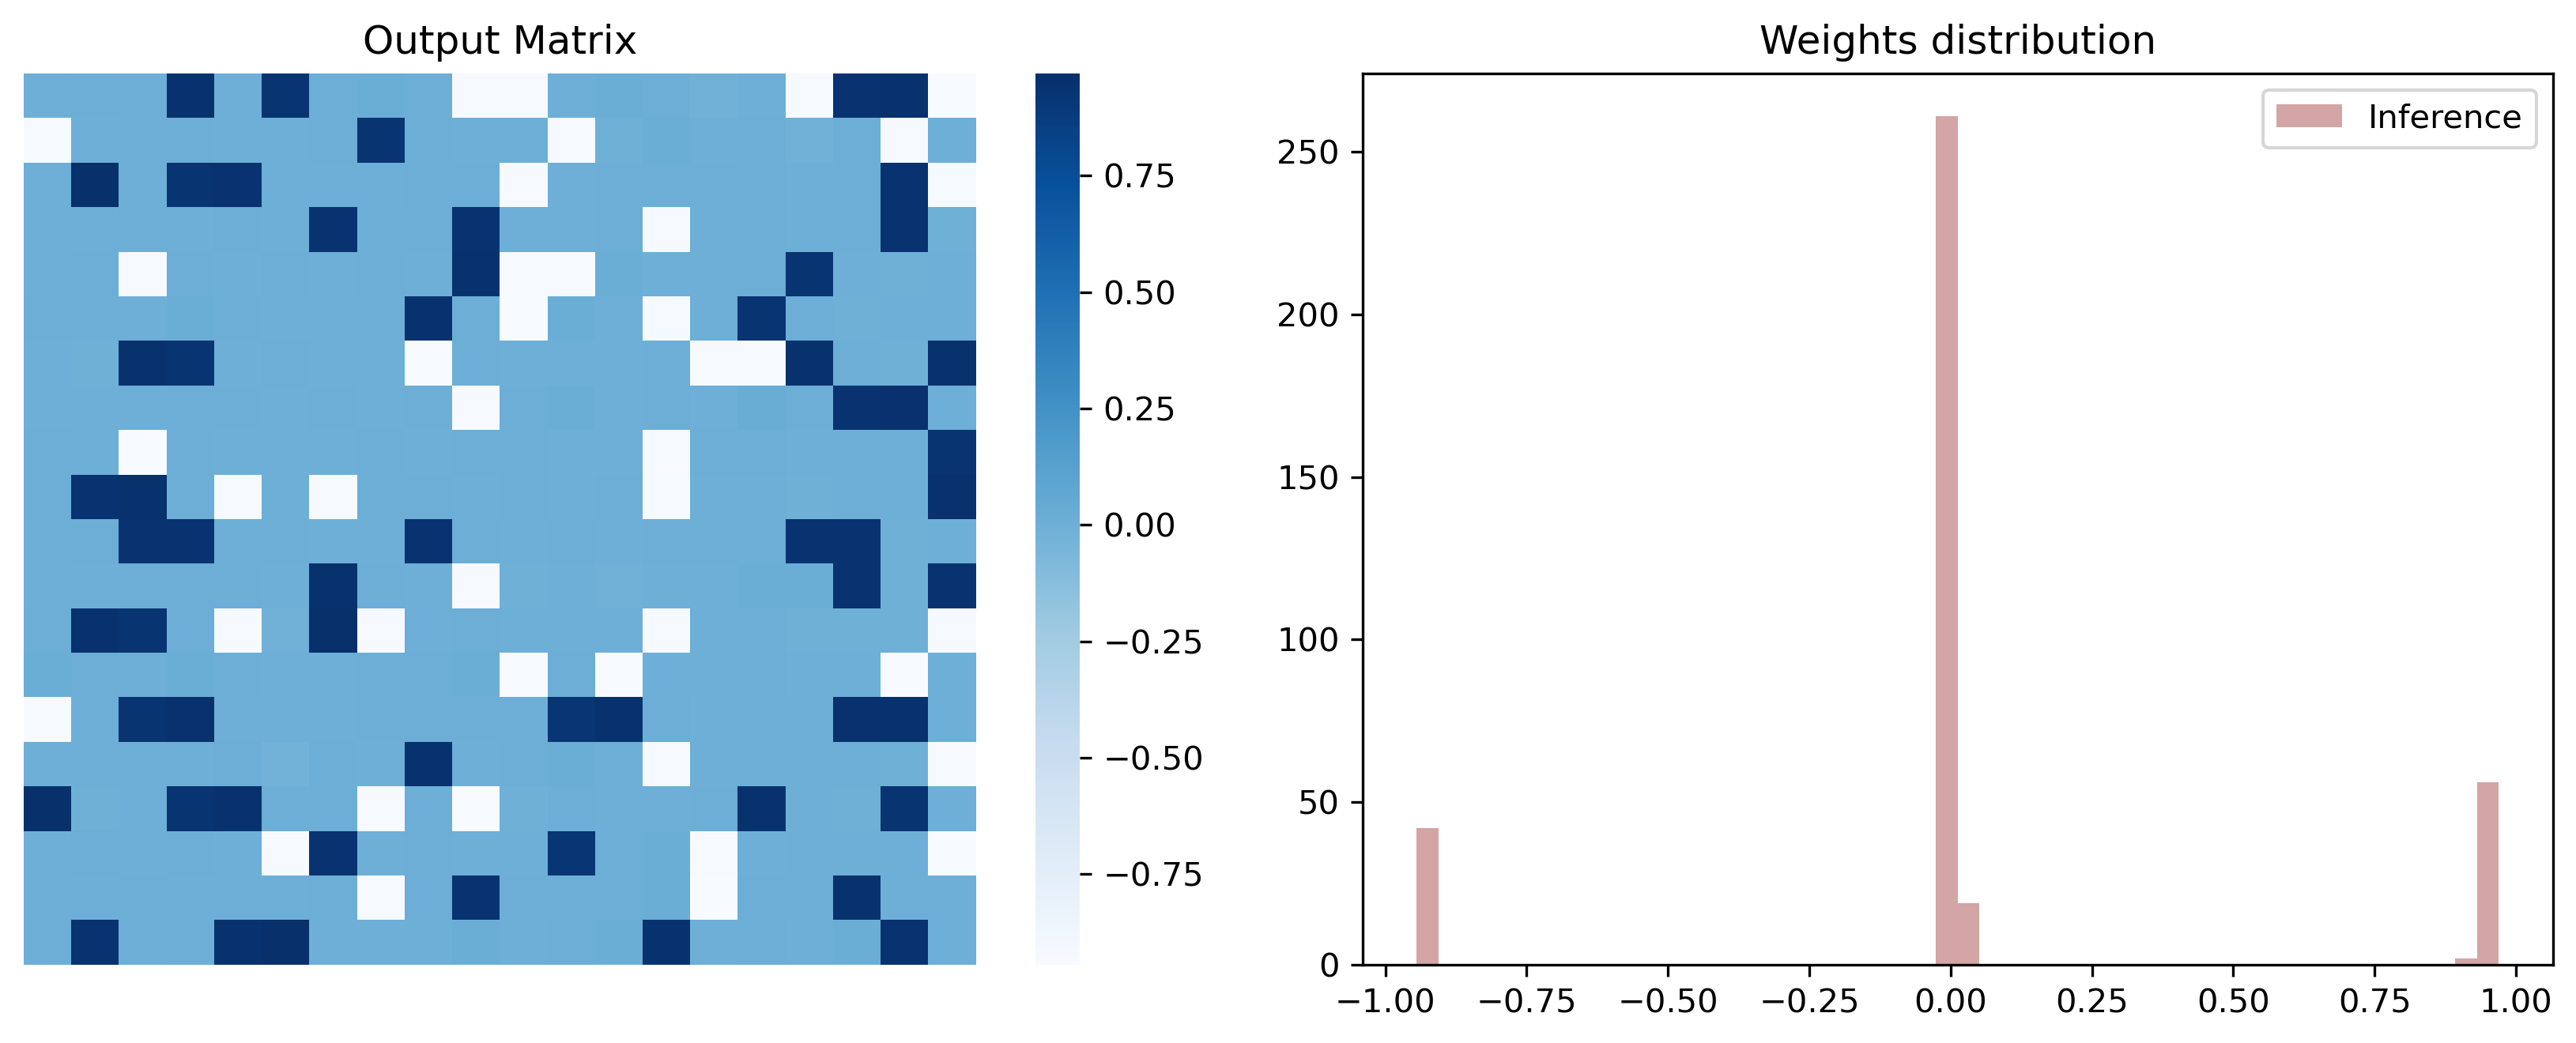

In [11]:
Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
Gweights = Gweights.view(-1,1).cpu()
# Gweights.cpu
bestWei = Gweights.detach().numpy()

nodes_num = args.Nodes_num
edge_num = nodes_num*(nodes_num-1)
bestWei = bestWei[:edge_num]

Stru = np.zeros((nodes_num, nodes_num))
mask = np.ones((nodes_num, nodes_num), dtype=bool)
np.fill_diagonal(mask, 0)
Stru[mask] = bestWei.squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
snb.heatmap(Stru, cmap='Blues', ax=ax1)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Output Matrix')
plt.hist(bestWei,bins=50,alpha=0.7, color='#C17F7E', label='Inference')
plt.legend()
ax2.set_title('Weights distribution')

# plt.savefig('figure2/HR20nodes_inference_results.pdf')

plt.tight_layout()
plt.show()

In [12]:
bistru = Stru.copy()
bistru = np.where(bistru<-0.5,-1,bistru)
bistru = np.where(bistru>0.4,1,bistru)
bistru = np.where((bistru>-0.5) & (bistru<0.4),0,bistru)
print(len(np.where(bistru==1)[0]))
print(len(np.where(bistru==-1)[0]))
print(len(np.where(bistru==0)[0]))

58
42
300


### weights distribution evolute over epochs

In [13]:
weights_chosen = []
epc_chosen = [1,100,300,400,600,1000]
epcstring = ['epoch=1','epoch=100','epoch=300','epoch=400','epoch=600','epoch=1000']
for e in epc_chosen:
    weights_ind = weights_over_epcs[e-1]
    weights_ind = torch.Tensor(weights_ind)
    Gweights = F.softmax(weights_ind/(0.999**(e-1)),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    bestWei = bestWei[:edge_num]
    weights_chosen.extend(bestWei)

print(len(weights_chosen))
print('number of edges:',int(len(weights_chosen)/len(epc_chosen)))

weights_chosen = pd.DataFrame(np.array(weights_chosen),columns=['weights'])
weights_chosen['epoch'] = np.repeat(epcstring,int(len(weights_chosen)/len(epc_chosen)))
print(weights_chosen.shape)

2280
number of edges: 380
(2280, 2)


#### ridgeline plots

380
number of edges: 13
(380, 29)


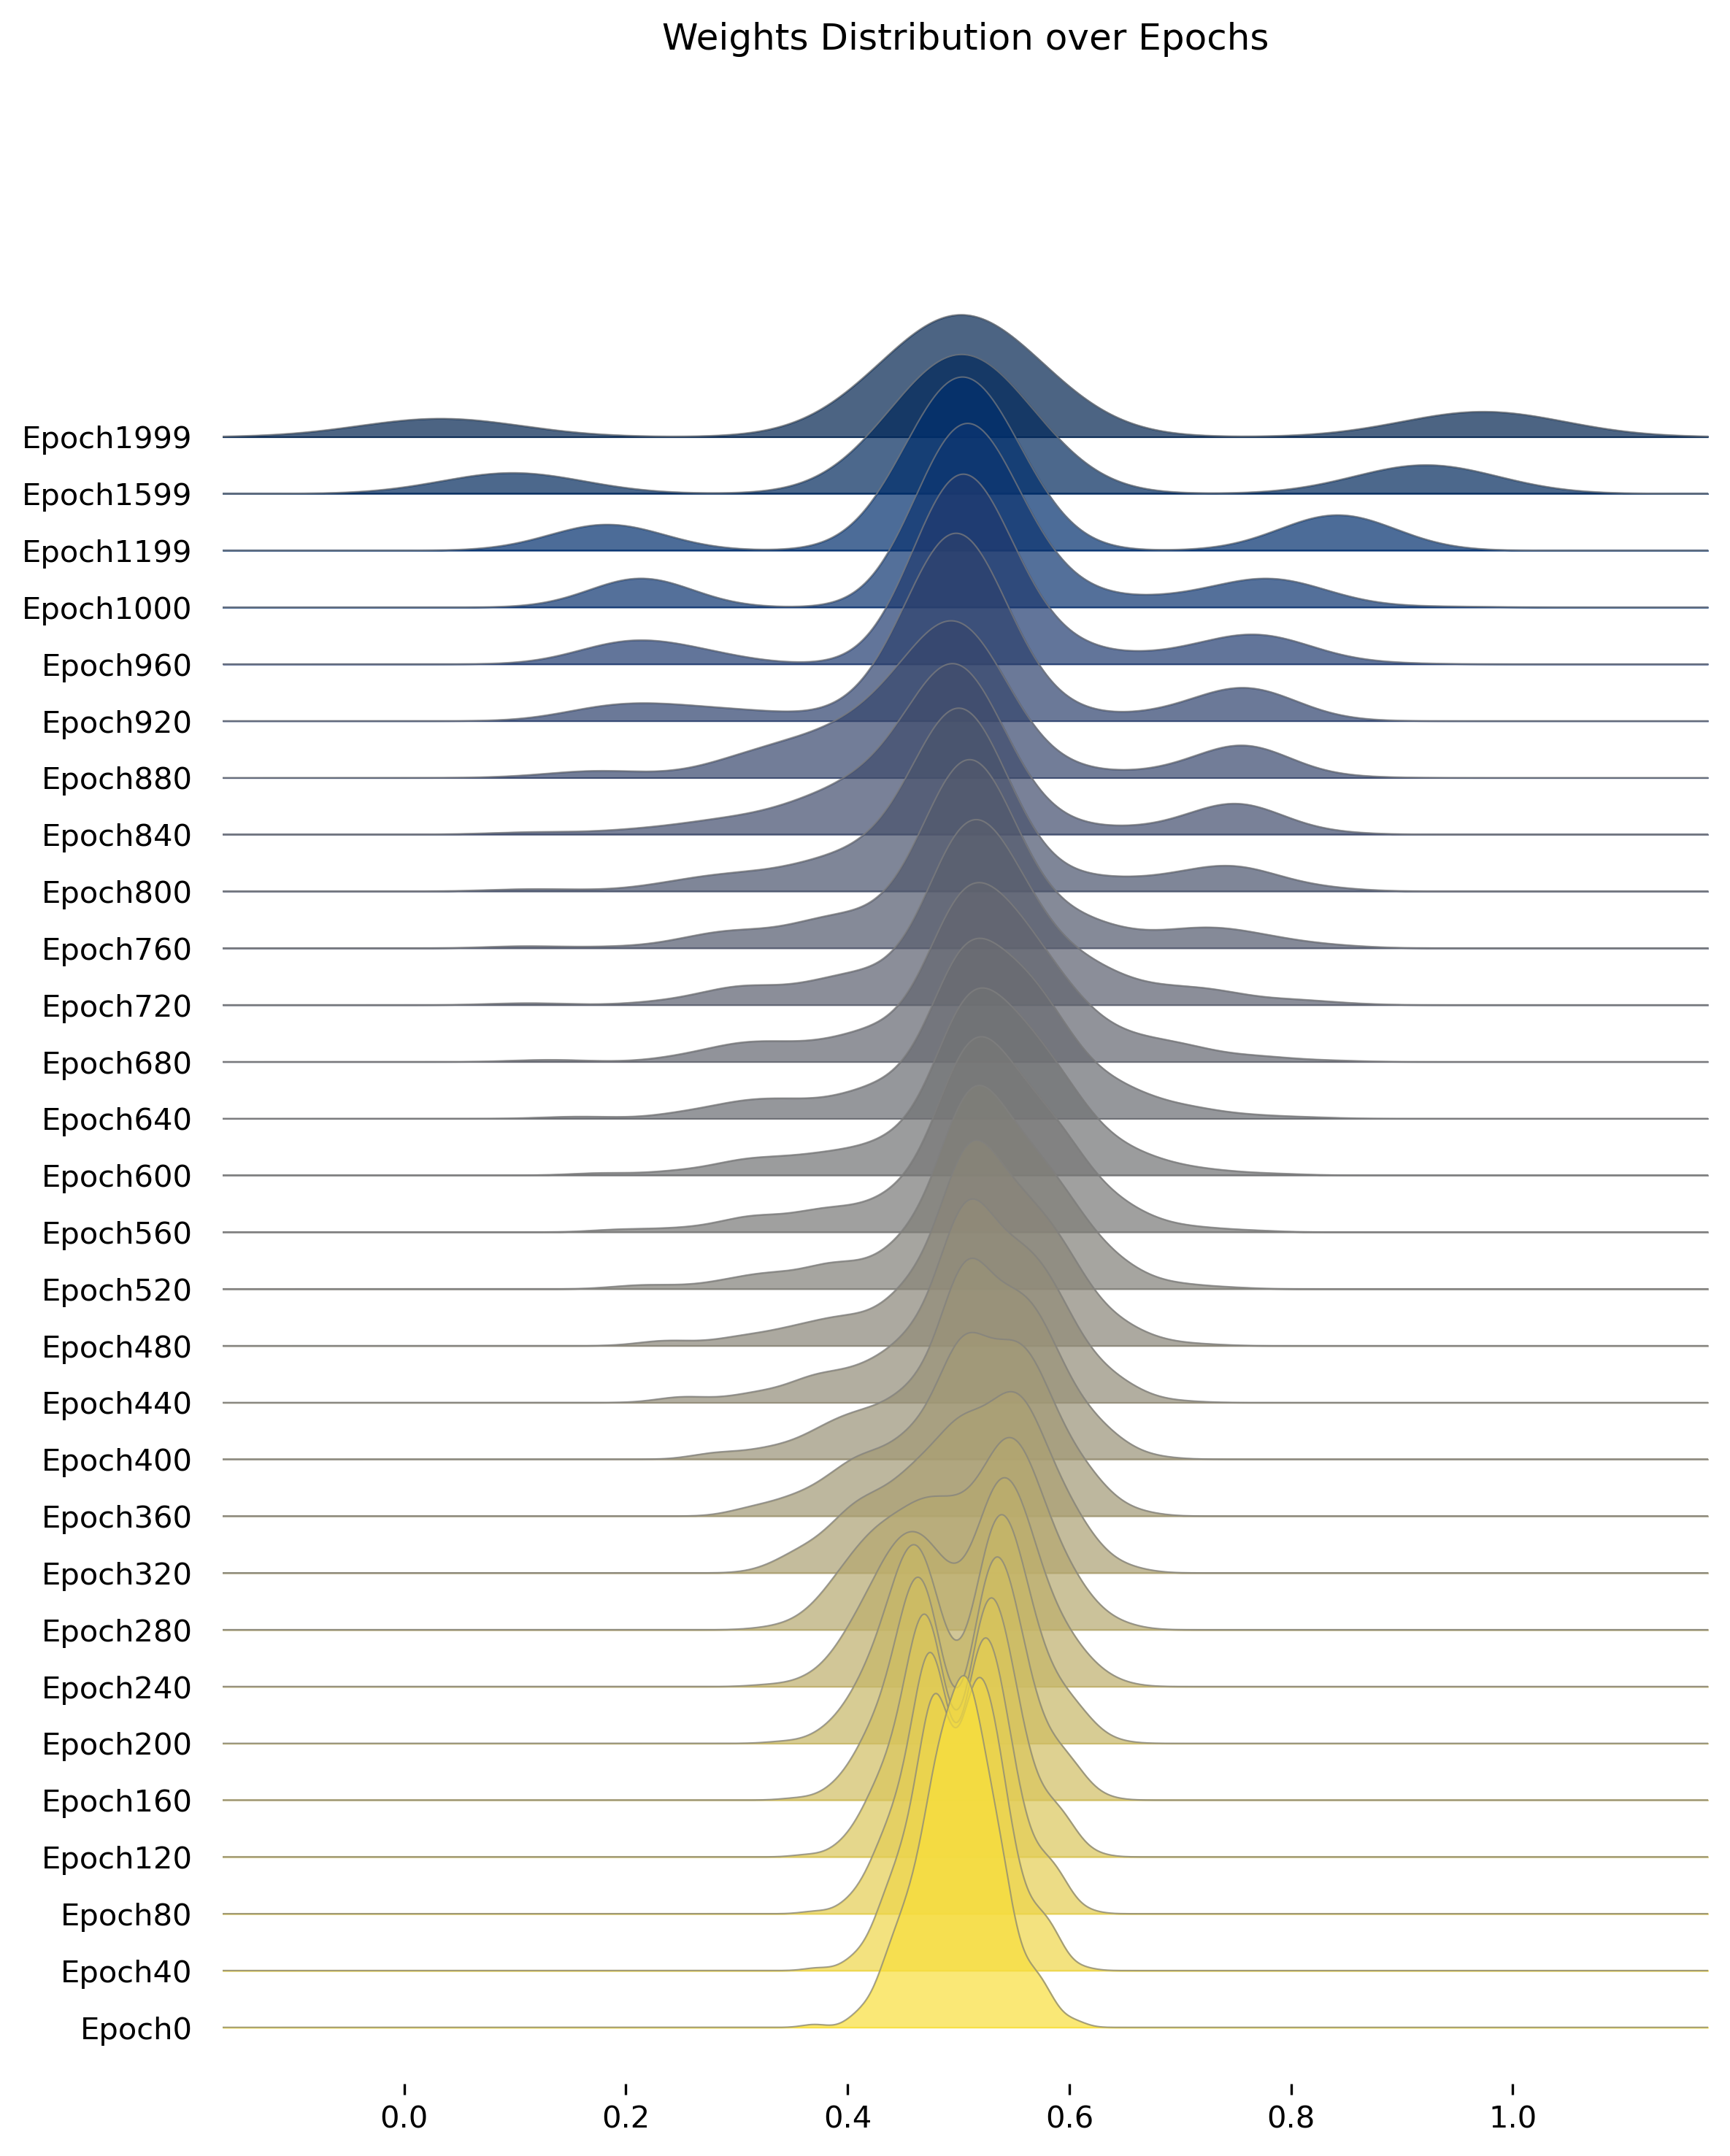

In [14]:
import pandas as pd
import numpy as np
import joypy
import matplotlib.pyplot as plt
nodes_num = 20
edge_num = nodes_num*(nodes_num-1)
weights_chosen = pd.DataFrame()
epc_chosen = np.arange(1,1040,40)
epc_chosen = epc_chosen.tolist()
epc_chosen.append(1200)
epc_chosen.append(1600)
epc_chosen.append(2000)
epc_chosen.reverse()
for e in epc_chosen:
    weights_ind = weights_over_epcs[e-1]
    weights_ind = torch.Tensor(weights_ind)
    Gweights = F.softmax(weights_ind/(0.999**(e-1)),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    bestWei = bestWei[:edge_num]
    weights_chosen[f'Epoch{e-1}'] = np.array(bestWei).reshape(-1)
    # weights_chosen.extend(bestWei)

print(len(weights_chosen))
print('number of edges:',int(len(weights_chosen)/len(epc_chosen)))
print(weights_chosen.shape)

plt.rcParams['figure.dpi']=300
fig, axes = joypy.joyplot(
    weights_chosen,
    figsize=(8, 10),
    overlap=2.5,
    colormap=plt.cm.cividis,
    title='Weights Distribution over Epochs', 
    linecolor='grey',
    linewidth=0.5,
    alpha=0.7,
)
# plt.savefig('figure2/v3/weights_distribution_over_epochs_less_reverse.pdf')
plt.show()


In [15]:
# Parameter setting
Trial = 1
Dimension = 3
dt = 0.01
Time = 500
nodes_num = 20
batch = args.Batch
Net = 'ER'

path = data_path + 'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)

series = series.reshape(-1, nodes_num, Dimension)
print(series.shape)
goal_data = series[1:-1,:,0:Dimension]
mapping_data = series[0:-2,:,0:Dimension]
print(goal_data.shape==mapping_data.shape)
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

(50000, 20, 3)
True


In [16]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [17]:
def get_edge_index(Adj): #target to source
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

pred_struc = np.abs(bistru)
edge_index = get_edge_index(pred_struc.T)
print('edge_num:', edge_index.shape[1])

edge_num: 100


In [49]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [50]:
pred_edgetype = np.round(Stru)
def get_edge_type(Adj,edge_index):
    edge_type = []
    for i in range(edge_index.shape[1]):
        edge_type.append(Adj[edge_index[1][i]][edge_index[0][i]])# source to target j to i
    edge_type = np.array(edge_type).reshape(-1,1)
    return edge_type

edge_type = get_edge_type(pred_edgetype,edge_index)
edge_type = torch.from_numpy(edge_type).to(device)

In [51]:
trainloader = DataLoader(
    [Data(
        X_train[i],
        edge_index=edge_index,
        y=y_train[i]) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=False
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=int(batch/2),
    shuffle=True
)

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [52]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from tqdm import tqdm
import pandas as pd

hidden = 100
Dyn = Retrain_sign_MP(n_f, msg_dim, dim, dt, edge_type, aggr=aggr, hidden=hidden).to(device)
Dyn = torch.compile(Dyn)
edge_index = edge_index.to(device)
init_lr = 5e-4
opt = torch.optim.AdamW(Dyn.parameters(), lr=init_lr, weight_decay=1e-6)
total_epochs = 100
batch_per_epoch = 1000
sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)


### Use inferred structure train the MLP (dynamics) again

In [53]:
import random
seed = 42 
torch.manual_seed(seed)       
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)

In [54]:
save_interval = 10
recorded_models = []
lose_over_epochs = []
valoss_over_epochs = []
for epoch in tqdm(range(total_epochs)):
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            ginput = ginput.to(device)
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            loss = Dyn.loss(ginput,square=True)
            loss.backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    Dyn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                ginput = ginput.to(device)
                if j>= batch_per_epoch:
                    break
                loss = Dyn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1

    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    lose_over_epochs.append(cur_loss)
    valoss_over_epochs.append(cur_valid_loss)
    
    from copy import deepcopy as copy
    if epoch % save_interval == 0:
        recorded_models.append(copy(Dyn.state_dict()))

if (total_epochs - 1) % save_interval != 0:
    recorded_models.append(copy(Dyn.state_dict()))

torch.save(recorded_models, save_path+f'retrain_recorded_models.pt')

  1%|          | 1/100 [00:09<15:59,  9.69s/it]

0.019838652522884585
0.0030730378713729133


  2%|▏         | 2/100 [00:19<15:51,  9.71s/it]

0.008031730130539023
0.0037406356948313964


  3%|▎         | 3/100 [00:28<15:36,  9.65s/it]

0.0066077853276669775
0.005094116280928337


  4%|▍         | 4/100 [00:38<15:25,  9.64s/it]

0.005638249407394528
0.005970080057913367


  5%|▌         | 5/100 [00:48<15:11,  9.59s/it]

0.004675765667701419
0.0059015635905423315


  6%|▌         | 6/100 [00:57<15:02,  9.60s/it]

0.003740923506790846
0.006393635793196351


  7%|▋         | 7/100 [01:07<14:59,  9.67s/it]

0.002869229153833372
0.006942412753082373


  8%|▊         | 8/100 [01:17<14:49,  9.67s/it]

0.0021136011590453642
0.006670519944139451


  9%|▉         | 9/100 [01:27<15:08,  9.98s/it]

0.001465651065396763
0.00447391112788005


 10%|█         | 10/100 [01:39<15:32, 10.36s/it]

0.0010248901091401052
0.002327376867095027


 11%|█         | 11/100 [01:51<16:05, 10.84s/it]

0.0007864690549526238
0.0016338140919430592


 12%|█▏        | 12/100 [02:01<15:54, 10.85s/it]

0.0006406606894588659
0.0014997501705538707


 13%|█▎        | 13/100 [02:12<15:42, 10.83s/it]

0.000549994860033802
0.0018598488847043784


 14%|█▍        | 14/100 [02:25<16:35, 11.58s/it]

0.00047752886738397434
0.0018075455700295106


 15%|█▌        | 15/100 [02:36<16:02, 11.32s/it]

0.00041981613113482446
0.0012104122494187796


 16%|█▌        | 16/100 [02:47<15:40, 11.20s/it]

0.00037315079815322894
0.0008924015432174966


 17%|█▋        | 17/100 [03:00<16:11, 11.71s/it]

0.00033443265050164936
0.0009244057268120852


 18%|█▊        | 18/100 [03:12<16:02, 11.74s/it]

0.0002969875090977468
0.001080230742561694


 19%|█▉        | 19/100 [03:22<15:03, 11.15s/it]

0.0002629359248549916
0.0009736069354102726


 20%|██        | 20/100 [03:32<14:27, 10.85s/it]

0.00023721944782945935
0.0007865573039633274


 21%|██        | 21/100 [03:43<14:24, 10.94s/it]

0.00021212266930693485
0.0006945302362216356


 22%|██▏       | 22/100 [03:54<14:21, 11.04s/it]

0.00019606375940150014
0.0007393602695228793


 23%|██▎       | 23/100 [04:05<14:04, 10.97s/it]

0.00017219676641082012
0.0006889071714181908


 24%|██▍       | 24/100 [04:17<14:22, 11.35s/it]

0.00015720024155114267
0.0006686362827288256


 25%|██▌       | 25/100 [04:29<14:25, 11.54s/it]

0.00014325923630989872
0.0005441603510596651


 26%|██▌       | 26/100 [04:39<13:36, 11.03s/it]

0.0001334872394721365
0.0005610282756552291


 27%|██▋       | 27/100 [04:49<13:01, 10.71s/it]

0.0001231172326263493
0.0005325478201430895


 28%|██▊       | 28/100 [05:00<13:05, 10.91s/it]

0.00011897712199496138
0.0005867621746761732


 29%|██▉       | 29/100 [05:11<12:44, 10.77s/it]

0.00010734656455194516
0.000568003717660166


 30%|███       | 30/100 [05:22<12:36, 10.81s/it]

0.00010131116578207784
0.0005864123346255831


 31%|███       | 31/100 [05:33<12:35, 10.95s/it]

9.789338732423061e-05
0.0006768093261107889


 32%|███▏      | 32/100 [05:43<11:56, 10.54s/it]

9.15414306850189e-05
0.0006013441108468601


 33%|███▎      | 33/100 [05:52<11:31, 10.32s/it]

8.206110216008153e-05
0.00050812143184701


 34%|███▍      | 34/100 [06:02<11:10, 10.16s/it]

7.50198279658005e-05
0.0003659878186744022


 35%|███▌      | 35/100 [06:12<10:49, 10.00s/it]

7.056571924329063e-05
0.0002968825379719907


 36%|███▌      | 36/100 [06:21<10:29,  9.84s/it]

6.068561193007198e-05
0.0003384221173871563


 37%|███▋      | 37/100 [06:31<10:16,  9.79s/it]

5.863565283279509e-05
0.0003446574482840476


 38%|███▊      | 38/100 [06:40<10:00,  9.69s/it]

5.379333735666482e-05
0.0002859538825824236


 39%|███▉      | 39/100 [06:50<09:46,  9.62s/it]

5.004725500774633e-05
0.0002934189576441059


 40%|████      | 40/100 [07:00<09:41,  9.69s/it]

4.689090331933942e-05
0.00027814019506606163


 41%|████      | 41/100 [07:09<09:30,  9.68s/it]

4.520395547936309e-05
0.00025572097236673034


 42%|████▏     | 42/100 [07:19<09:19,  9.64s/it]

4.109073322089581e-05
0.0002372752105650647


 43%|████▎     | 43/100 [07:29<09:09,  9.65s/it]

3.843062079790989e-05
0.00022186024206054247


 44%|████▍     | 44/100 [07:39<09:06,  9.75s/it]

3.7161732964815604e-05
0.00019439016071958078


 45%|████▌     | 45/100 [07:48<08:56,  9.75s/it]

3.233343738691838e-05
0.0001903886151734774


 46%|████▌     | 46/100 [07:58<08:44,  9.72s/it]

3.15489107189516e-05
0.00017949006205976158


 47%|████▋     | 47/100 [08:08<08:33,  9.70s/it]

2.8951804096536783e-05
0.0001673697640696627


 48%|████▊     | 48/100 [08:17<08:26,  9.74s/it]

2.6344322173018875e-05
0.0001534804122210132


 49%|████▉     | 49/100 [08:27<08:14,  9.69s/it]

2.545899948721358e-05
0.00013236701564118443


 50%|█████     | 50/100 [08:37<08:02,  9.65s/it]

2.3016349443381838e-05
0.00012162116225435824


 51%|█████     | 51/100 [08:46<07:50,  9.61s/it]

2.2244699577626378e-05
0.00011473008104787918


 52%|█████▏    | 52/100 [08:56<07:40,  9.58s/it]

2.0551524923694833e-05
0.00011045366778936155


 53%|█████▎    | 53/100 [09:05<07:29,  9.56s/it]

1.8397489645295803e-05
9.492832530379583e-05


 54%|█████▍    | 54/100 [09:15<07:19,  9.55s/it]

1.7909505280530935e-05
9.478234826948714e-05


 55%|█████▌    | 55/100 [09:24<07:10,  9.57s/it]

1.6147599912466488e-05
8.767746103249024e-05


 56%|█████▌    | 56/100 [09:36<07:28, 10.20s/it]

1.53064093703262e-05
8.625766591501367e-05


 57%|█████▋    | 57/100 [09:47<07:30, 10.48s/it]

1.412901223600383e-05
7.62676941811472e-05


 58%|█████▊    | 58/100 [09:59<07:38, 10.92s/it]

1.3653101523731079e-05
6.937046847554371e-05


 59%|█████▉    | 59/100 [10:11<07:36, 11.15s/it]

1.3169265271734048e-05
6.0616530323176294e-05


 60%|██████    | 60/100 [10:23<07:36, 11.41s/it]

1.1254740171037289e-05
5.375458509809961e-05


 61%|██████    | 61/100 [10:34<07:28, 11.51s/it]

1.0729498581196796e-05
5.1444399451823165e-05


 62%|██████▏   | 62/100 [10:45<07:03, 11.15s/it]

1.0312282165673834e-05
4.8494841923092895e-05


 63%|██████▎   | 63/100 [10:57<07:01, 11.40s/it]

9.490159605155883e-06
4.301355903557405e-05


 64%|██████▍   | 64/100 [11:08<06:53, 11.50s/it]

9.039019373064496e-06
3.651343073024774e-05


 65%|██████▌   | 65/100 [11:20<06:43, 11.53s/it]

8.602867409086922e-06
3.0597425715787734e-05


 66%|██████▌   | 66/100 [11:32<06:34, 11.59s/it]

8.084789389174228e-06
2.2374956337913777e-05


 67%|██████▋   | 67/100 [11:44<06:26, 11.71s/it]

7.183053673020638e-06
2.46945800788516e-05


 68%|██████▊   | 68/100 [11:55<06:07, 11.49s/it]

6.872231511532795e-06
1.8382775326724648e-05


 69%|██████▉   | 69/100 [12:05<05:44, 11.10s/it]

6.307833840562484e-06
1.7485790849950742e-05


 70%|███████   | 70/100 [12:16<05:36, 11.22s/it]

5.94444195810052e-06
1.2984434040736849e-05


 71%|███████   | 71/100 [12:26<05:13, 10.82s/it]

5.555162006777856e-06
1.061702620652356e-05


 72%|███████▏  | 72/100 [12:36<04:55, 10.54s/it]

5.2155105314833344e-06
9.15739757947703e-06


 73%|███████▎  | 73/100 [12:46<04:40, 10.40s/it]

4.947322289340163e-06
7.339843193150736e-06


 74%|███████▍  | 74/100 [12:56<04:24, 10.16s/it]

4.674078581127456e-06
6.207964627502527e-06


 75%|███████▌  | 75/100 [13:07<04:22, 10.50s/it]

4.450056387221431e-06
5.684973006497095e-06


 76%|███████▌  | 76/100 [13:17<04:05, 10.24s/it]

4.138262677717225e-06
6.3581165243635385e-06


 77%|███████▋  | 77/100 [13:28<04:01, 10.48s/it]

3.960514452417946e-06
6.493891074429634e-06


 78%|███████▊  | 78/100 [13:38<03:49, 10.43s/it]

3.762573625371847e-06
5.814528456960399e-06


 79%|███████▉  | 79/100 [13:48<03:34, 10.21s/it]

3.5526879631601696e-06
4.250265804254239e-06


 80%|████████  | 80/100 [13:58<03:21, 10.07s/it]

3.3185823610165143e-06
4.278853256625193e-06


 81%|████████  | 81/100 [14:08<03:10, 10.01s/it]

3.1233567876882258e-06
4.249809622138114e-06


 82%|████████▏ | 82/100 [14:17<02:58,  9.91s/it]

3.01360327843134e-06
3.5442324879195107e-06


 83%|████████▎ | 83/100 [14:27<02:47,  9.88s/it]

2.8042434174916734e-06
2.8435864955400208e-06


 84%|████████▍ | 84/100 [14:37<02:36,  9.81s/it]

2.5855303042120148e-06
2.509227981107778e-06


 85%|████████▌ | 85/100 [14:46<02:26,  9.77s/it]

2.498834413153765e-06
2.2901323606087206e-06


 86%|████████▌ | 86/100 [14:56<02:16,  9.75s/it]

2.3950153348241807e-06
2.349098324316633e-06


 87%|████████▋ | 87/100 [15:06<02:06,  9.70s/it]

2.3381370781188075e-06
2.567295122050288e-06


 88%|████████▊ | 88/100 [15:15<01:55,  9.65s/it]

2.292368960205337e-06
2.360097873233912e-06


 89%|████████▉ | 89/100 [15:25<01:45,  9.61s/it]

2.3302886373922077e-06
2.007142864276336e-06


 90%|█████████ | 90/100 [15:34<01:35,  9.59s/it]

2.4217835784371874e-06
2.7560475009678994e-06


 91%|█████████ | 91/100 [15:44<01:26,  9.57s/it]

2.4083441314408163e-06
1.8925713007977553e-06


 92%|█████████▏| 92/100 [15:53<01:16,  9.56s/it]

2.219664972040132e-06
1.5029476682765037e-06


 93%|█████████▎| 93/100 [16:03<01:06,  9.56s/it]

2.17875779304732e-06
1.3177432038488011e-06


 94%|█████████▍| 94/100 [16:12<00:57,  9.55s/it]

2.0814803276827566e-06
1.3910952996306316e-06


 95%|█████████▌| 95/100 [16:22<00:48,  9.67s/it]

2.1738829763194785e-06
1.667217924657254e-06


 96%|█████████▌| 96/100 [16:32<00:38,  9.64s/it]

2.3040489829117356e-06
4.245073417522866e-06


 97%|█████████▋| 97/100 [16:41<00:28,  9.61s/it]

2.189251996102452e-06
1.3441151742842121e-06


 98%|█████████▊| 98/100 [16:51<00:19,  9.59s/it]

1.990695224945412e-06
1.5697755766531538e-06


 99%|█████████▉| 99/100 [17:01<00:09,  9.57s/it]

1.9710326874128214e-06
1.1993355575268276e-06


100%|██████████| 100/100 [17:10<00:00, 10.31s/it]

1.904989685121712e-06
1.1318661434351566e-06


### Load the recorded model

In [56]:
device = torch.device('cpu')
# recorded_models = torch.load(save_path+f'recorded_models.pt')
Dyn = Retrain_sign_MP(n_f, msg_dim, dim, dt, edge_type, aggr=aggr, hidden=hidden).to(device)
Dyn = torch.compile(Dyn)
Dyn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [57]:
np.random.seed(20)
test_idxes = np.random.randint(0, len(X_test), 100)

X_test = X_test.to(device)
y_test = y_test.to(device)

newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [58]:
import numpy as onp
import pandas as pd

def get_messages(ogn, dim, msg_dim, loader):

    def get_message_info(tmp):
        tmp = tmp.to(device)
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        Tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        Tmp = Tmp.reshape(2,-1)
        Tmp = Tmp.t()# tmp has shape [E, 2 * in_channels]
        Len = int(s1.shape[0])/int(edge_type.shape[0])
        T = edge_type.repeat(int(Len),1)
        
        Tmp.cpu()
        w_type1 = torch.where(T>0,T,0)
        w_type2 = torch.where(T<0,-T,0)
        tmpT = torch.cat([Tmp,T],dim=1)
        tmpT = tmpT.to(torch.float32)
        
        m12_type1 = ogn.msg_fnc_type1(Tmp)
        m12_type2 = ogn.msg_fnc_type2(Tmp)
        m12 = m12_type1*w_type1+m12_type2*w_type2

        all_messages = torch.cat((
            tmpT,m12_type1, m12_type2,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['Gtype1']
            columns += ['Gtype2']
            columns += ['message']
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['Gtype1']
            columns += ['Gtype2']
            columns += ['message']
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['Gtype1']
            columns += ['Gtype2']
            columns += ['message']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [59]:
def get_selfDynamics(ogn, dim, loader):
    def get_selfDynamics_info(tmp):
        tmp = tmp.to(device)
        ogn.cpu()
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(loader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [60]:
edge_index = edge_index.to(device)
edge_type = edge_type.to(device)

In [61]:
msgs = get_messages(Dyn, dim=Dimension, msg_dim=1, loader=newtestloader)
selfdyn = get_selfDynamics(Dyn,dim=Dimension, loader=newtestloader)

In [62]:
# x1 (x_i) is target, x2 (x_j) is source 
msg_type2 = msgs[msgs['T'] < -0.5] 
x_i = msg_type2['x1'].values
x_j = msg_type2['x2'].values
G_type22 = msg_type2.iloc[:,-2].values

if np.sum(G_type22 > 0):
    coup_value_exc = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) 
    print("G_type22 values are excitary.")
else:
    coup_value_inh = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) 
    print("G_type22 values are inhibitory.")

msg_type1 = msgs[msgs['T'] > 0.5 ]
x_i = msg_type1['x1'].values
x_j = msg_type1['x2'].values
G_type11 = msg_type1.iloc[:,-3].values
if np.sum(G_type11 < 0):
    coup_value_inh = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory
    print("G_type11 values are inhibitory.")
else:
    coup_value_exc = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) # excitary
    print("G_type11 values are excitary.")

G_type22 values are excitary.
G_type11 values are inhibitory.


In [63]:
np.random.seed(2024)
num = 500
# index = np.random.randint(0, 40000, num)
index = np.arange(0, num,1)

Text(0, 0.5, 'Inferred type2 interactions')

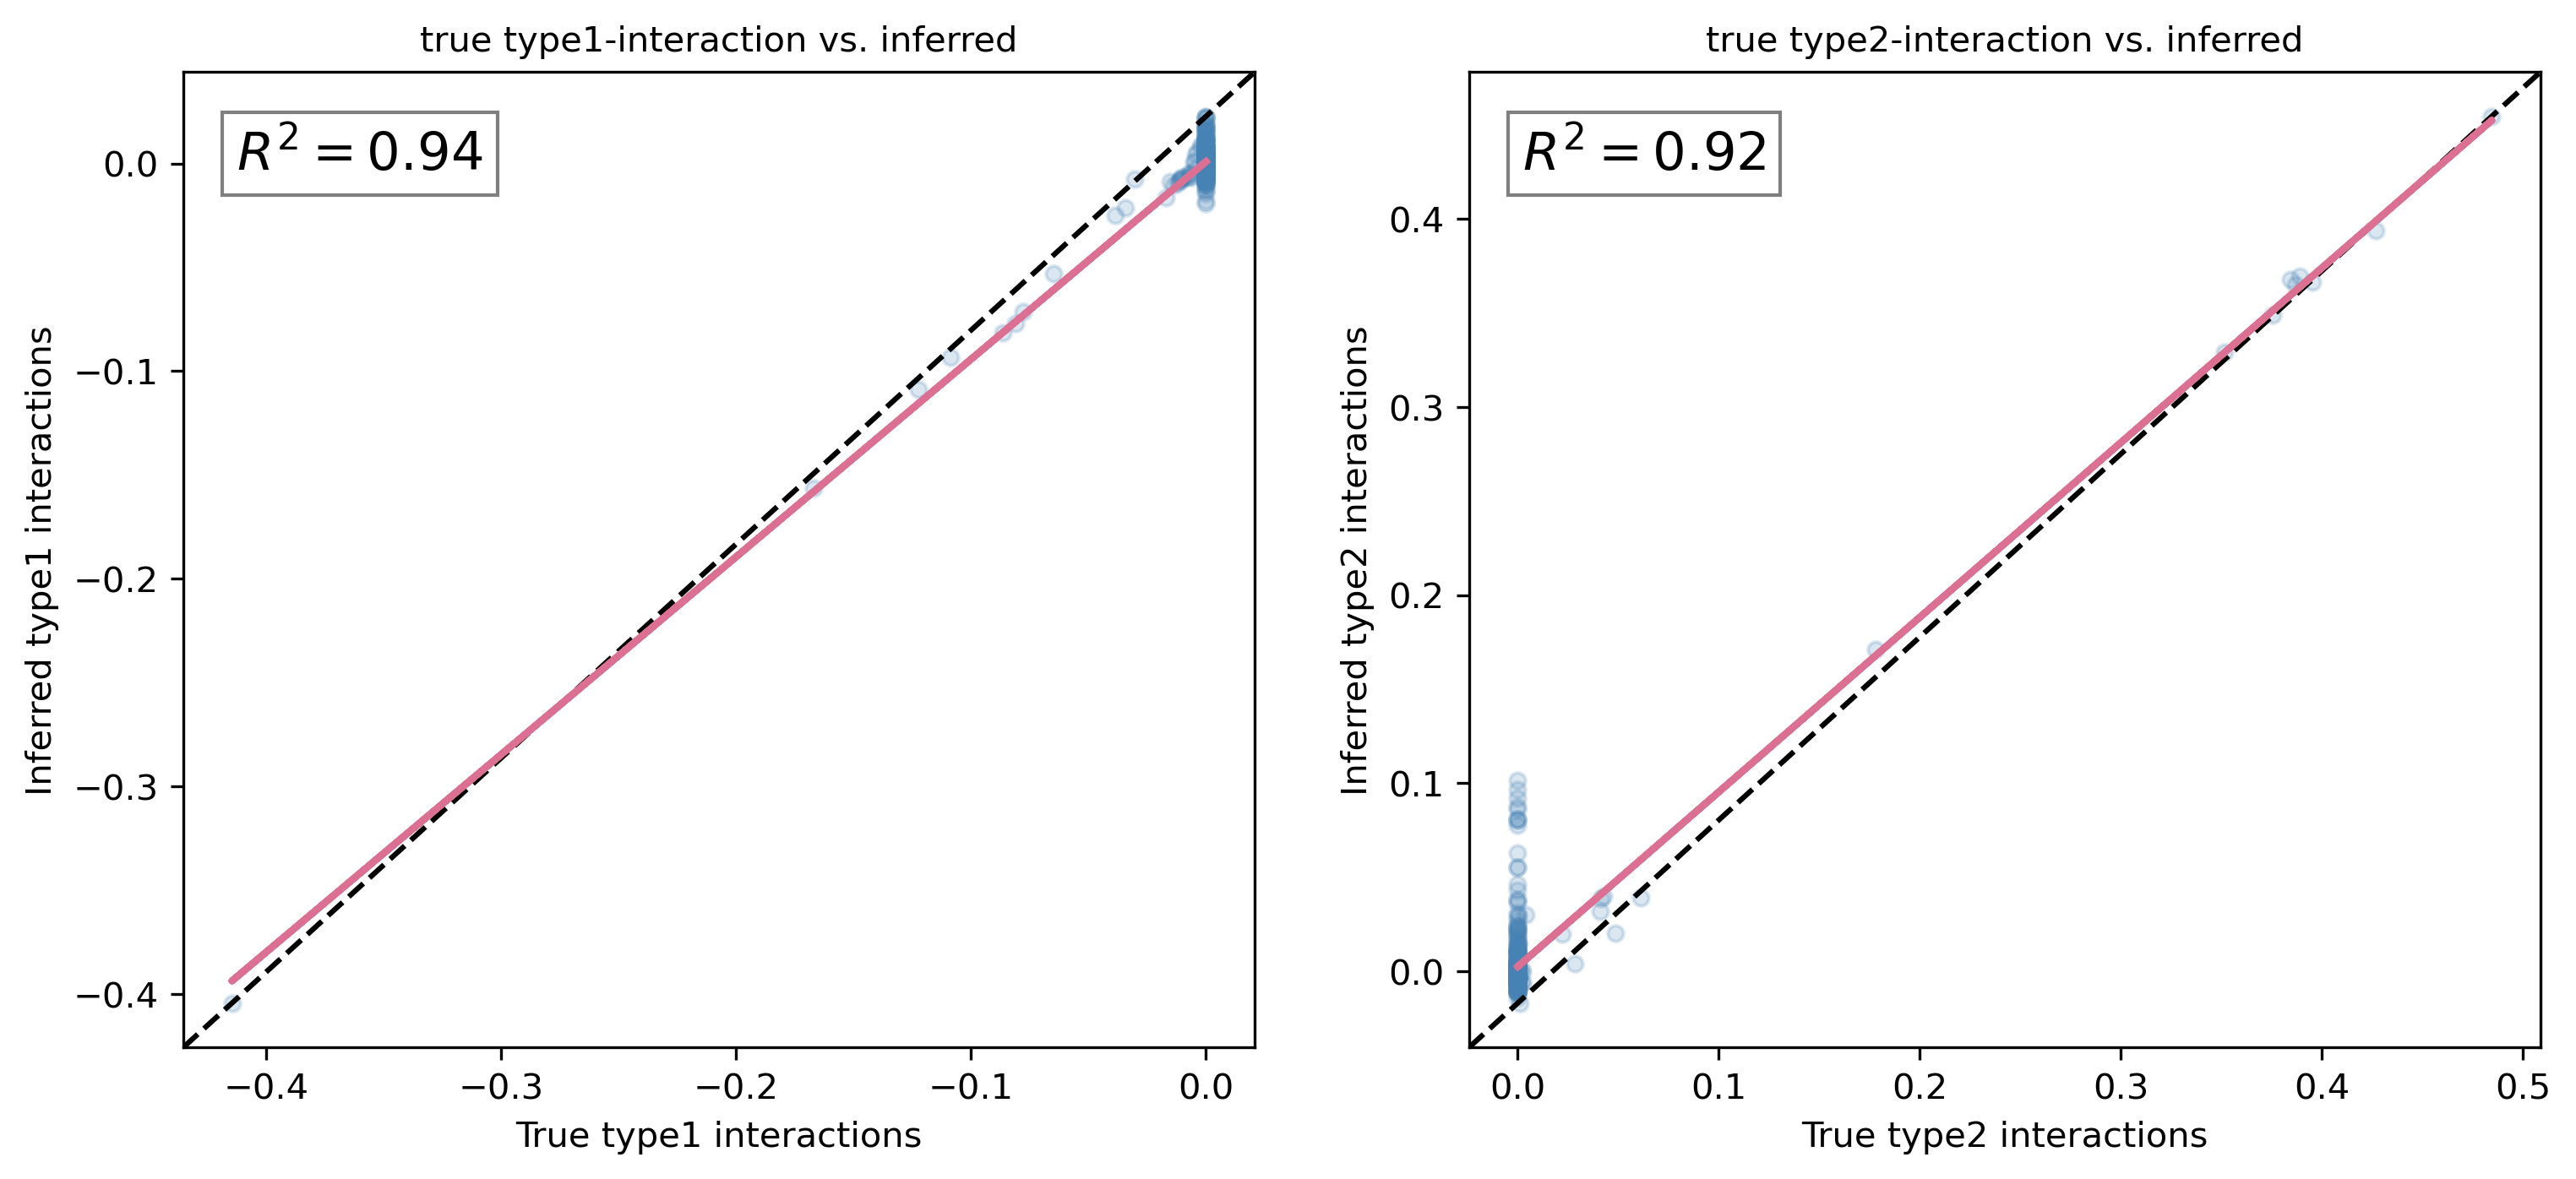

In [64]:
G_type2 = G_type22[index]
G_type1 = G_type11[index]
coup_value_inh = coup_value_inh[index]
coup_value_exc = coup_value_exc[index]
import matplotlib as mpl
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1)
plt.title("true type1-interaction vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(coup_value_inh,G_type1,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(coup_value_inh,G_type1,1)
fx = np.poly1d(parameterx)
ax1.plot(coup_value_inh,fx(coup_value_inh),c='palevioletred',lw=2)
corrx = np.corrcoef(coup_value_inh,G_type1)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True type1 interactions")
plt.ylabel("Inferred type1 interactions")

ax2 = fig.add_subplot(1,2,2)
plt.title("true type2-interaction vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(coup_value_exc,G_type2,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(coup_value_exc,G_type2,1)
fy = np.poly1d(parametery)
ax2.plot(coup_value_exc,fy(coup_value_exc),c='palevioletred',lw=2)
corry = np.corrcoef(coup_value_exc,G_type2)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True type2 interactions")
plt.ylabel("Inferred type2 interactions")
# plt.savefig('retrain_inference_results_lr5e-4.pdf')

In [65]:
import pandas as pd
coup_value_type1 = np.array(coup_value_inh)
G_type1 = np.array(G_type1)
type1 = pd.concat([pd.DataFrame(coup_value_type1),pd.DataFrame(G_type1)],axis=1)
coup_value_type2 = np.array(coup_value_exc)
G_type2 = np.array(G_type2)
type2 = pd.concat([pd.DataFrame(coup_value_type2),pd.DataFrame(G_type2)],axis=1)

interact = pd.concat([type1,type2],axis=0)
interact.columns = ['True','Inferred']
interact['Interaction'] = ['Type1-dyn']*num+['Type2-dyn']*num

In [66]:
# interact.to_csv('retrain_interact_results.csv',index=False)

1.0


Text(0.65, 0.05, '$R^2=1.00$')

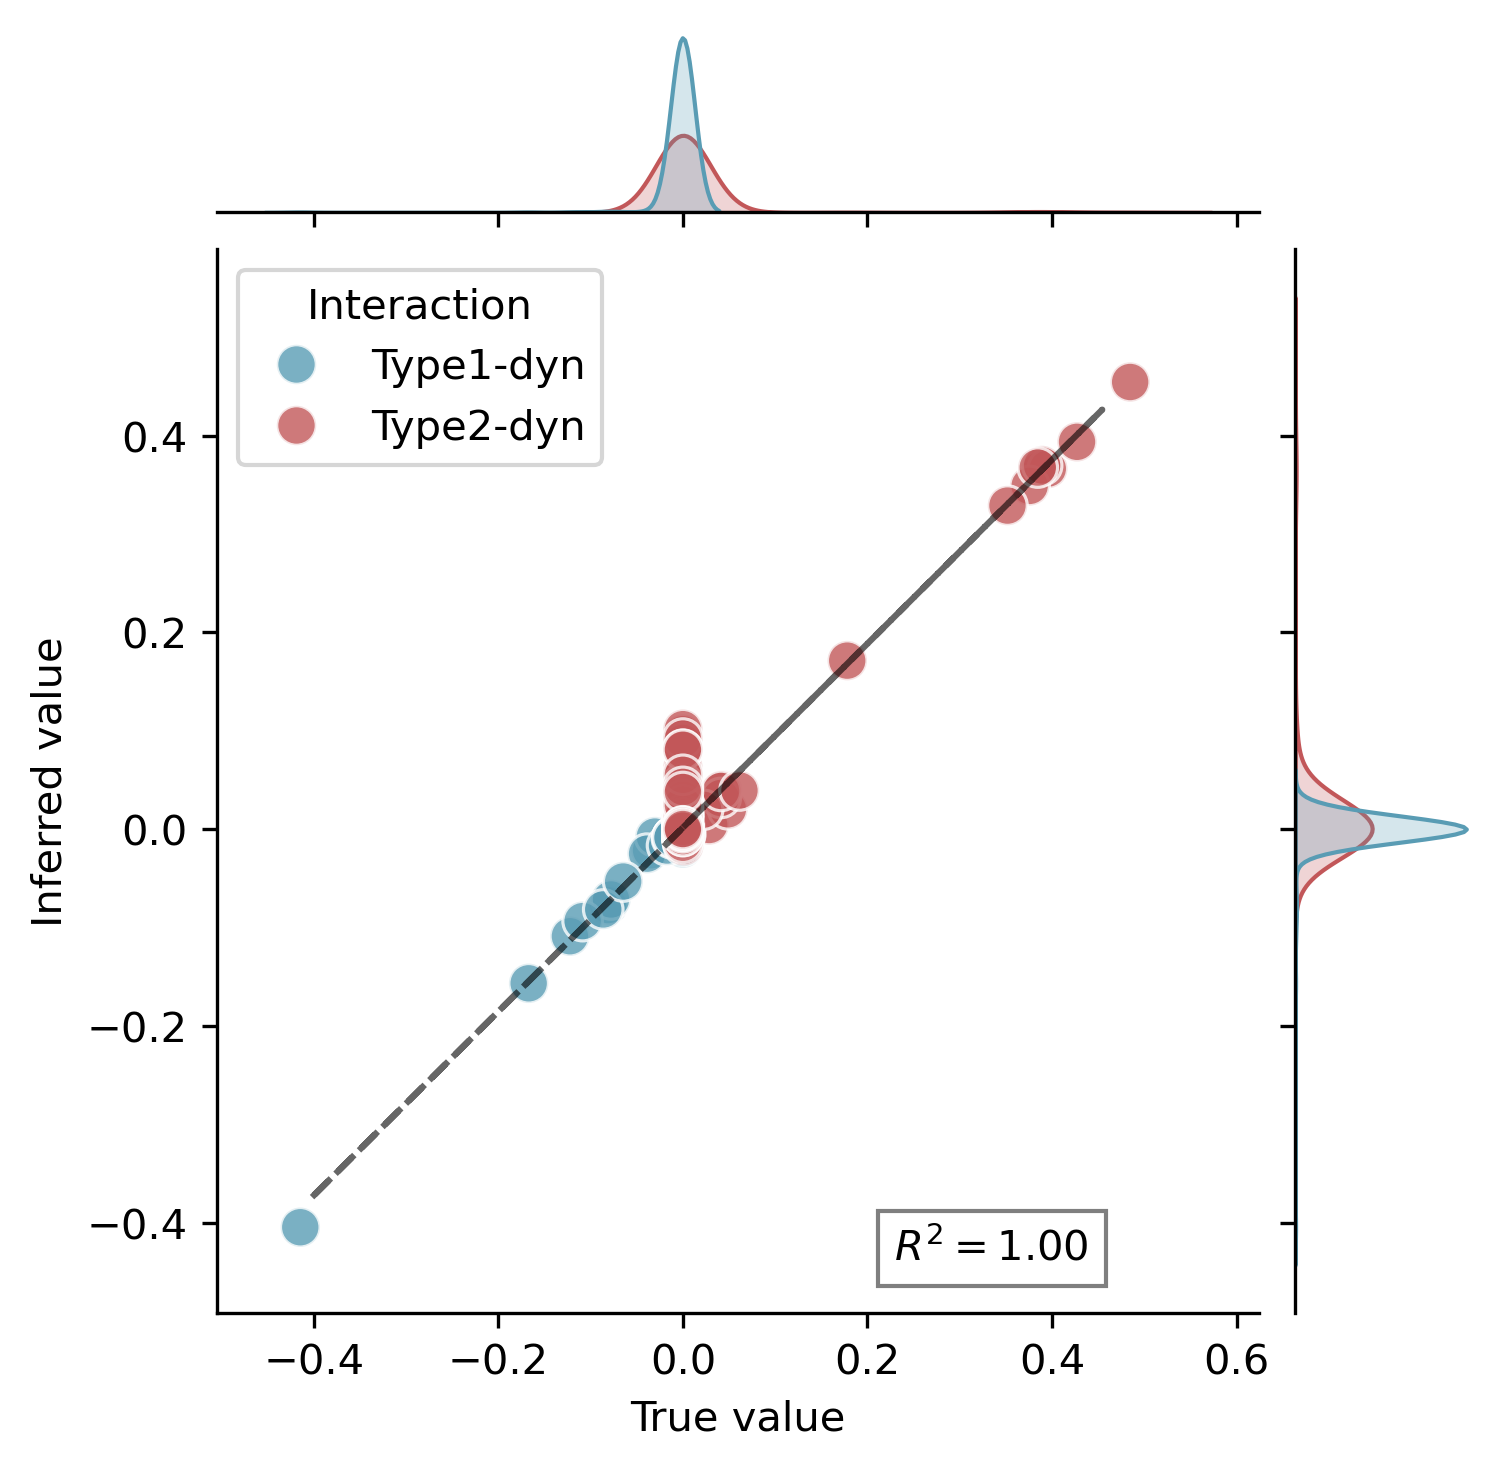

In [67]:
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.style.use('default') 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
# figure = plt.figure(figsize=(10,10))

# palette = ['#8D91C0','#B8ACB9']
palette = ['#599CB4','#C25759']
g = sns.jointplot(data=interact, kind='scatter', 
                  x="True", y="Inferred",
                  hue='Interaction',
                  alpha=0.8, palette = palette,
                  joint_kws=dict(s=90),
                  marginal_kws=dict(bw_adjust=2),
                  height=5,             
)

g.ax_joint.set(
    xlabel='True value', 
    ylabel='Inferred value',
    )

parameterx = np.polyfit(interact['True'].values,interact['Inferred'].values,1)
fx = np.poly1d(parameterx)
g.ax_joint.plot(interact['Inferred'].values,fx(interact['Inferred'].values),alpha = 0.6,c='k',linestyle='--',lw=1.5)
corrx = np.corrcoef(interact['Inferred'].values,fx(interact['Inferred'].values))[0,1]
print(corrx**2)
bbox = dict(fc='1',alpha=0.5,facecolor='white')
plt.text(0.65, 0.05, '$R^2=%.2f$' % (corrx**2), transform=g.ax_joint.transAxes, size=10, bbox=bbox)

# interact['Residual'] = (interact['True'] - interact['Inferred'])
# plt.savefig('figure2/v6/HR20nodes_2type_interaction_fitting_anothercolor.pdf')

### equation inference

In [68]:
from utils.Interaction_func import *
from utils.Self_func import *
msg_type2 = msgs[msgs['T'] < -0.5]
xi = msg_type2['x1'].values
xj = msg_type2['x2'].values
G_type22 = msg_type2.iloc[:,-2].values
# coup_value_type22 = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory
goal = G_type22.reshape(-1,1) # G(xi,xj)
goal = pd.DataFrame(data = goal, columns =['e0'])
EleMatrix = ElementaryFunctions_Matrix(xi,xj)
EleMatrix = EleMatrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [69]:
print(EleMatrix.columns)

Index(['xj', 'xixj', 'xjMinusxi', 'sinxj', 'sinxixj', 'sinxjMinusxi',
       'xisinxj', 'expxj', 'expxixj', 'expxjMinusxi', 'xiexpxj', 'fracxj',
       'fracxixj', 'fracxjMinusxi', 'xifracxj', 'sigmoidxj', 'sigmoidxixj',
       'sigmoidXjMinusXi', 'xisigmoidxj', 'sigmoidxj101', 'sigmoidxixj101',
       'sigmoidXjMinusXi101', 'xisigmoidxj101', 'tanhxj', 'tanhxixj',
       'tanhxjMinusxi', 'xitanhxj', 'hillxj', 'hillxixj', 'hillxjMinusxi',
       'xihillxj', 'hillxj2', 'hillxixj2', 'hillxjMinusxi2', 'hillxj5',
       'hillxixj5', 'hillxjMinusxi5'],
      dtype='object')


In [70]:
X = EleMatrix.copy()
y = goal.copy()

X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:] # pandas
out = np.array(y) # shape(n,1)
y1 = (out[:,0]) # shape(n,)

In [71]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9473179161100284
Best threshold: 0.021


In [72]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
expxjMinusxi          -0.000268
sigmoidXjMinusXi101   -0.000840
tanhxj                -0.001510
xiexpxj                0.005644
xitanhxj               0.008063
sigmoidxj             -0.017611
sinxjMinusxi           0.019017
hillxjMinusxi2         0.031373
xisigmoidxj101        -0.124036
sigmoidxj101           0.274571
dtype: float64


In [73]:
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept, n_jobs=-1, max_iter=1000).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [74]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = EleMatrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = EleMatrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X,columns=[imp_no_cons.index[-1]])
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score > 0.95:
        break

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101    0.353171
dtype: float64
0.899059096092007 0.00035523447279751404 -33357.476498994845 sigmoidxj101
sigmoidxj101      0.286392
xisigmoidxj101   -0.098068
dtype: float64
0.9247161631442041 0.00026494129793031316 -34587.20954979503 xisigmoidxj101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.278111
xisigmoidxj101   -0.094190
hillxjMinusxi2    0.013329
dtype: float64
0.9286921191064178 0.0002509489859396211 -34813.095707582106 hillxjMinusxi2
sigmoidxj101      0.266914
xisigmoidxj101   -0.091738
hillxjMinusxi2    0.017162
sinxjMinusxi      0.013535
dtype: float64
0.9391267134112262 0.0002142272263434993 -35475.58786384527 sinxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.267713
xisigmoidxj101   -0.092521
hillxjMinusxi2    0.018220
sinxjMinusxi      0.013753
sigmoidxj        -0.001334
dtype: float64
0.9392144626746209 0.0002139184163159134 -35479.64656075374 sigmoidxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.281290
xisigmoidxj101   -0.097077
hillxjMinusxi2    0.041364
sinxjMinusxi      0.017171
sigmoidxj        -0.036130
xitanhxj          0.012068
dtype: float64
0.9463248113759894 0.0001888954486729898 -36000.1308858798 xitanhxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.271785
xisigmoidxj101   -0.131331
hillxjMinusxi2    0.039583
sinxjMinusxi      0.020455
sigmoidxj        -0.025404
xitanhxj          0.012349
xiexpxj           0.007628
dtype: float64
0.9478541983461647 0.0001835131809002662 -36119.54106262674 xiexpxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101      0.281730
xisigmoidxj101   -0.127276
hillxjMinusxi2    0.036427
sinxjMinusxi      0.023780
sigmoidxj        -0.029727
xitanhxj          0.008041
xiexpxj           0.007522
tanhxj           -0.006593
dtype: float64
0.9484862642997437 0.00018128879408481295 -36168.76085336838 tanhxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101           0.281730
xisigmoidxj101        -0.127276
hillxjMinusxi2         0.036427
sinxjMinusxi           0.023780
sigmoidxj             -0.029727
xitanhxj               0.008040
xiexpxj                0.007522
tanhxj                -0.006594
sigmoidXjMinusXi101    0.000000
dtype: float64
0.9484862681130822 0.0001812887806647894 -36166.761164276184 sigmoidXjMinusXi101
sigmoidxj101           0.275204
xisigmoidxj101        -0.098287
hillxjMinusxi2         0.028347
sinxjMinusxi           0.016883
sigmoidxj             -0.018559
xitanhxj               0.006347
xiexpxj                0.001381
tanhxj                -0.002011
sigmoidXjMinusXi101   -0.000000
expxjMinusxi          -0.000000
dtype: float64
0.9453998686874675 0.0001921505367057315 -35920.37208074793 expxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


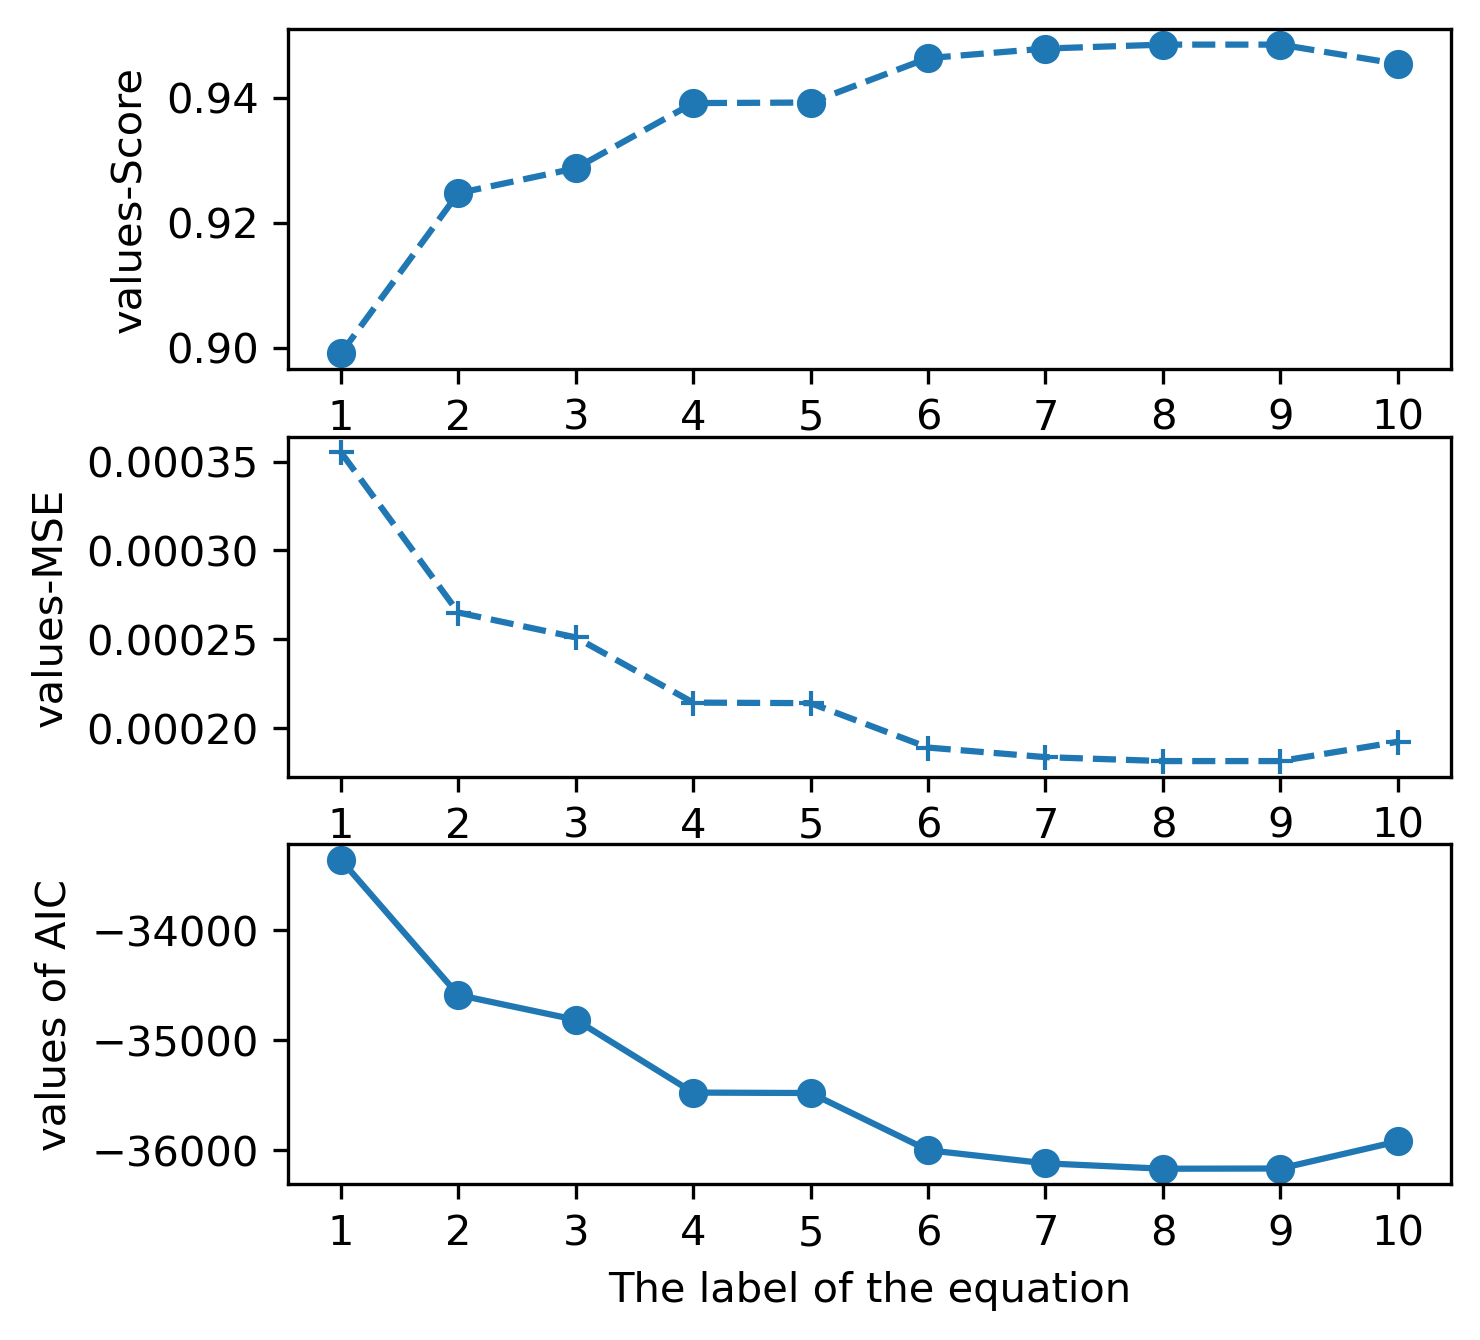

In [75]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_inhibitory_equation.pdf')
plt.show()

In [76]:
X = EleMatrix.copy()
y = goal.copy()

Xfind_inh = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)
yfind_inh = y['e0']#dim
model_lineari = LinearRegression(fit_intercept=False)
model_lineari.fit(Xfind_inh,yfind_inh)
ai = model_lineari.coef_
ai

array([ 0.28724999, -0.10048752])

In [140]:
# coup_value_type22 = 0.15*(2-x_i)/(1+np.exp(-10*(x_j-1))) # excitatory

In [77]:
t = [0.3,-0.15]
sm = 0
for i in range(len(ai)):
    s = np.abs(ai[i]-t[i])/(np.abs(ai[i])+np.abs(t[i]))
    sm += s
smape_Gi = sm/len(ai)
print(smape_Gi)
smape_Gi = np.mean(np.abs(ai - t) / (np.abs(ai + t)))
smape_Gi

0.10968792369758386


0.10968792369758386

In [78]:
msg_type1 = msgs[msgs['T'] > 0.5]
# msg_type1 = msgs[msgs['T'] >0.5]
xi = msg_type1['x1'].values
xj = msg_type1['x2'].values
G_type11 = msg_type1.iloc[:,-3].values
goal = G_type11.reshape(-1,1) # G(xi,xj)
goal = pd.DataFrame(data = goal, columns =['e0'])
EleMatrix = ElementaryFunctions_Matrix(xi,xj)
EleMatrix = EleMatrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [79]:
X = EleMatrix.copy()
y = goal.copy()

X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:] # pandas
out = np.array(y) # shape(n,1)
y1 = (out[:,0]) # shape(n,)

In [80]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9534759312958877
Best threshold: 0.014


In [81]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
expxixj               -0.002195
xiexpxj                0.002384
xisinxj                0.002444
expxj                 -0.003152
xitanhxj               0.003707
sinxjMinusxi           0.005198
sigmoidXjMinusXi101   -0.008892
hillxjMinusxi2         0.013791
xisigmoidxj101        -0.146841
sigmoidxj101          -0.211610
dtype: float64


In [82]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = EleMatrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = EleMatrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X,columns=[imp_no_cons.index[-1]])
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score>0.95:
        break

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101   -0.087176
dtype: float64
0.5050006140842122 0.0001909748216894932 -49665.539980889684 sigmoidxj101
sigmoidxj101     -0.211766
xisigmoidxj101   -0.148598
dtype: float64
0.9158298543554154 3.2473532318255995e-05 -59939.494105665304 xisigmoidxj101
sigmoidxj101     -0.215168
xisigmoidxj101   -0.147170
hillxjMinusxi2    0.005115
dtype: float64
0.9211821249900565 3.0408582423028518e-05 -60318.55690252376 hillxjMinusxi2


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.216366
xisigmoidxj101        -0.146663
hillxjMinusxi2         0.004292
sigmoidXjMinusXi101    0.002213
dtype: float64
0.9215498263854083 3.026672020984138e-05 -60343.67839347866 sigmoidXjMinusXi101


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.215758
xisigmoidxj101        -0.150076
hillxjMinusxi2         0.009921
sigmoidXjMinusXi101   -0.011090
sinxjMinusxi           0.007826
dtype: float64
0.941201477781972 2.268495197305949e-05 -62014.09081944815 sinxjMinusxi


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.215813
xisigmoidxj101        -0.150310
hillxjMinusxi2         0.009637
sigmoidXjMinusXi101   -0.010594
sinxjMinusxi           0.007642
xitanhxj               0.000344
dtype: float64
0.9413458144335782 2.2629265709423532e-05 -62026.3459697384 xitanhxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoidxj101          -0.202877
xisigmoidxj101        -0.147690
hillxjMinusxi2         0.012331
sigmoidXjMinusXi101   -0.007595
sinxjMinusxi           0.007894
xitanhxj               0.001438
expxj                 -0.003291
dtype: float64
0.9425692120187166 2.2157268890185276e-05 -62146.6007025077 expxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004473123733875761, tolerance: 0.00018453279742021032
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009496504138915007, tolerance: 0.00018453279742021032
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anacond

sigmoidxj101          -0.202901
xisigmoidxj101        -0.147692
hillxjMinusxi2         0.012326
sigmoidXjMinusXi101   -0.007605
sinxjMinusxi           0.007894
xitanhxj               0.001435
expxj                 -0.003284
xisinxj                0.000000
dtype: float64
0.9425702492021589 2.2156868736309112e-05 -62144.70544977826 xisinxj
sigmoidxj101          -0.197113
xisigmoidxj101        -0.138764
hillxjMinusxi2         0.012561
sigmoidXjMinusXi101   -0.009136
sinxjMinusxi           0.007421
xitanhxj               0.000938
expxj                 -0.004230
xisinxj                0.000000
xiexpxj               -0.001913
dtype: float64
0.9422719880918743 2.227194031816197e-05 -62112.66113027728 xiexpxj


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034940697962557166, tolerance: 0.00017477829288356647
  model = cd_fast.enet_coordinate_descent_gram(
/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036580550547778146, tolerance: 0.00015735510140902408
  model = cd_fast.enet_coordinate_descent_gram(


sigmoidxj101          -0.202263
xisigmoidxj101        -0.148635
hillxjMinusxi2         0.018069
sigmoidXjMinusXi101   -0.007665
sinxjMinusxi           0.007023
xitanhxj               0.000000
expxj                 -0.003013
xisinxj                0.008529
xiexpxj               -0.000155
expxixj               -0.002275
dtype: float64
0.9492471153349189 1.9580879037272628e-05 -62857.550757866346 expxixj


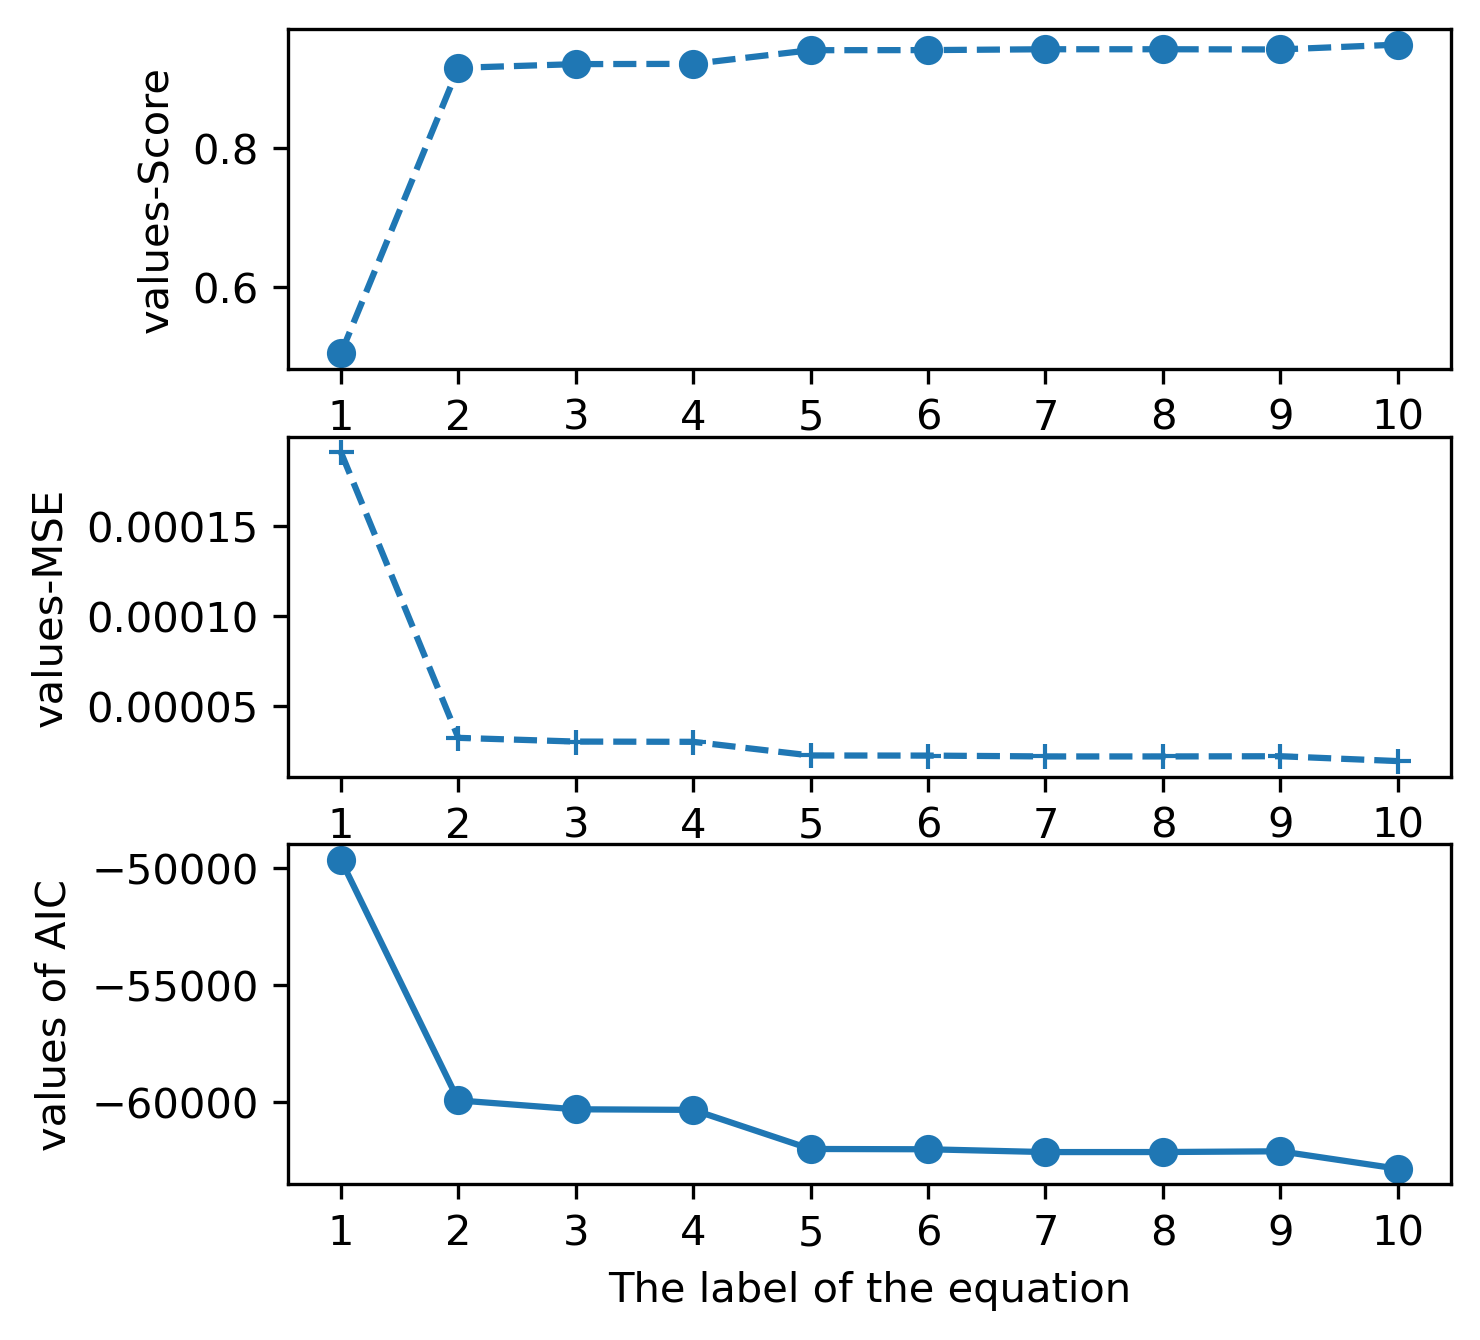

In [83]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_excitory_equation.pdf')
plt.show()

In [84]:
X = EleMatrix.copy()
y = goal.copy()

Xfind_exi = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)
yfind_exi = y['e0']#dim
model_lineare = LinearRegression(fit_intercept=False)
model_lineare.fit(Xfind_exi,yfind_exi)
ae = model_lineare.coef_
ae

array([-0.21234118, -0.14917988])

In [233]:
# coup_value_type11 = 0.15*(-1.5-x_i)/(1+np.exp(-10*(x_j-1))) # inhibitory

In [85]:
t = [-0.225,-0.15]
sm = 0
for i in range(len(ae)):
    s = np.abs(ae[i]-t[i])/(np.abs(ae[i])+np.abs(t[i]))
    sm += s
smape_Ge = sm/len(ae)
print(smape_Ge)

0.015843092077712145


so, type2 is excitatory, and type1 is inhibitory

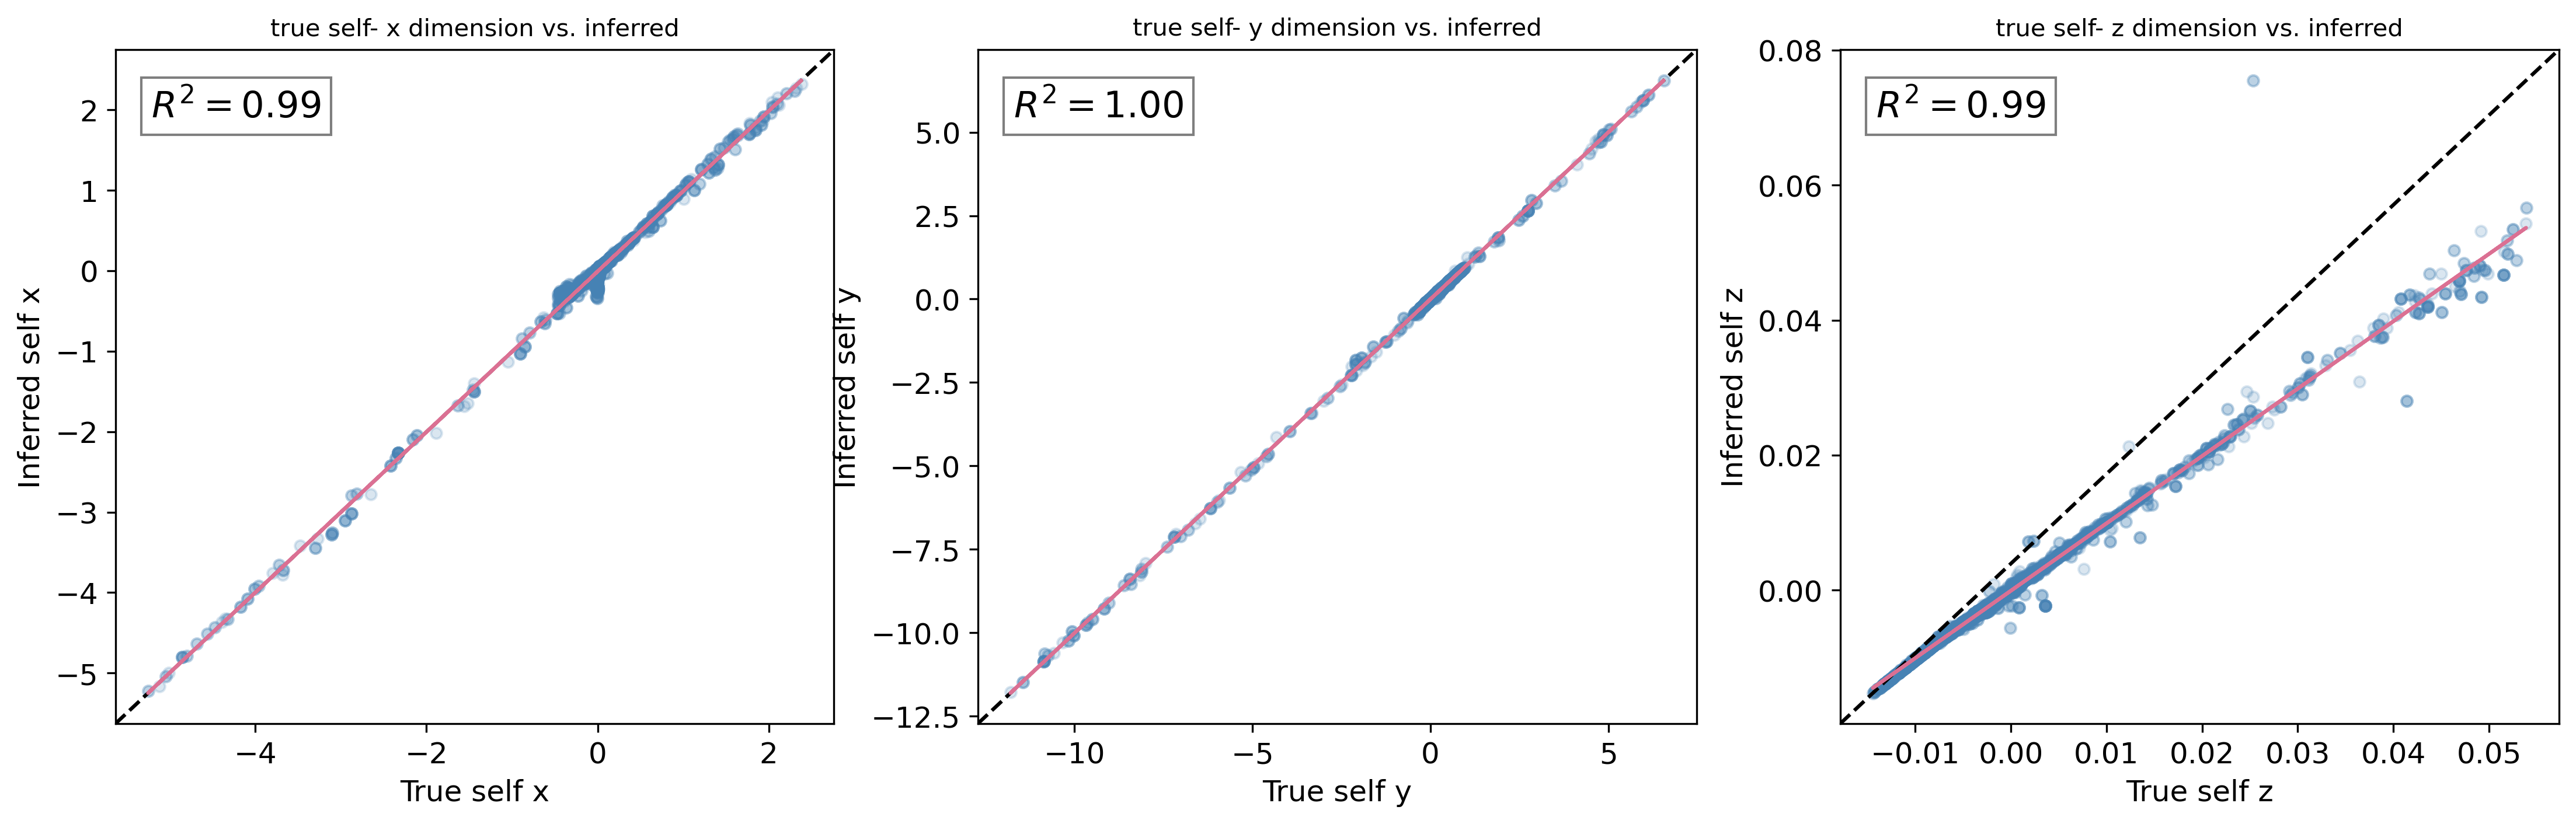

In [86]:
import random
import matplotlib.pyplot as plt
best_selfDyn = selfdyn
sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])

R = random.sample(range(0,len(selfdyn['s2'])),4000) 
sx = sx[R]
sx_true = sx_true[R]
sy = sy[R]
sy_true = sy_true[R]
sz = sz[R]
sz_true = sz_true[R]

plt.rcParams.update({'font.size': 12}) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
# plt.savefig('figure2/HR20nodes_selfDynamics_fitting.pdf')
plt.show()
plt.close()

In [87]:
import pandas as pd
sx_true = np.array(sx_true)
sx = np.array(sx)
xdim = pd.concat([pd.DataFrame(sx_true),pd.DataFrame(sx)],axis=1)
sy_true = np.array(sy_true)
sy = np.array(sy)
ydim = pd.concat([pd.DataFrame(sy_true),pd.DataFrame(sy)],axis=1)
sz_true = np.array(sz_true)
sz = np.array(sz)
zdim = pd.concat([pd.DataFrame(sz_true),pd.DataFrame(sz)],axis=1)
selfF = pd.concat([xdim,ydim,zdim],axis=0)
selfF.columns = ['True','Inferred']
selfF['Dimension'] = ['x-dim']*len(R)+['y-dim']*len(R)+['z-dim']*len(R)

Text(0.65, 0.05, '$R^2=1.00$')

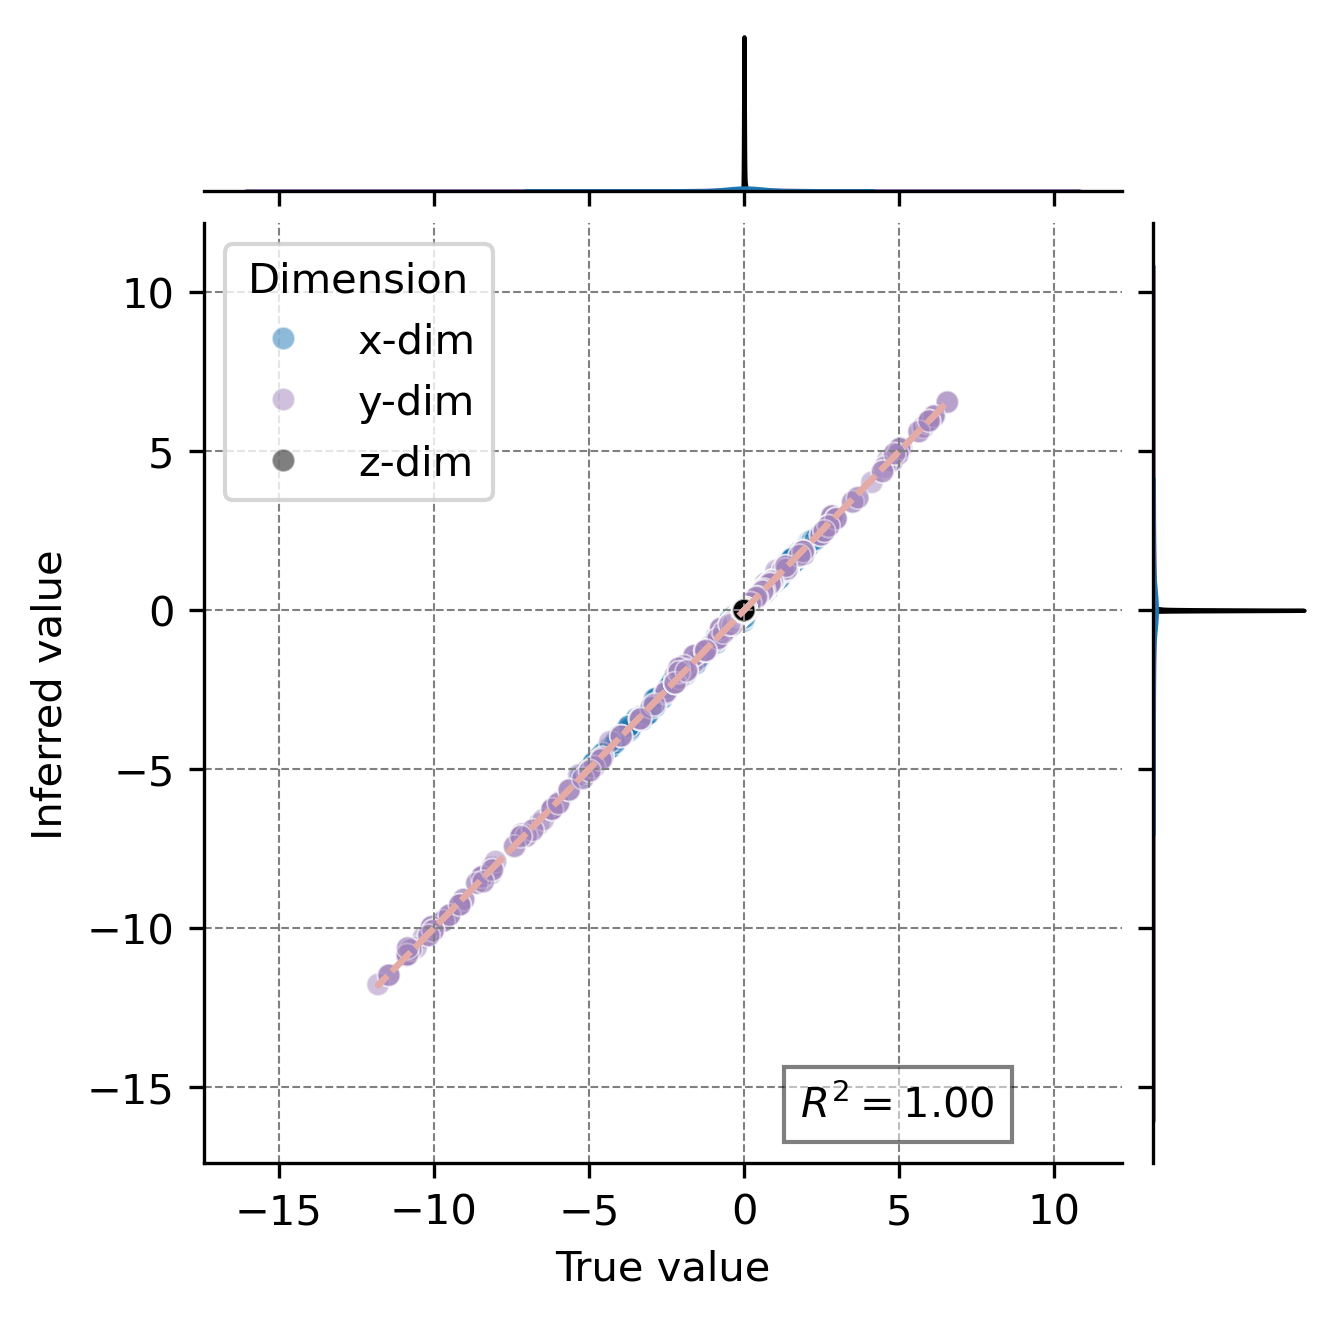

In [88]:
import seaborn as sns
import matplotlib as mpl
import scipy.optimize as sciopt
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.style.use('default') 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
g = sns.jointplot(data=selfF, kind='scatter', 
                  x="True", y="Inferred",
                  hue='Dimension',
                  alpha=0.5, palette = ['C20','#A184BC','k'],
                  joint_kws=dict(s=30),
                  marginal_kws=dict(bw_adjust=5),
                  height=4.5,             
)

g.ax_joint.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

g.ax_joint.set(
    xlabel='True value', 
    ylabel='Inferred value',
    )

parameterx = np.polyfit(selfF['True'].values,selfF['Inferred'].values,1)
fx = np.poly1d(parameterx)
g.ax_joint.plot(selfF['True'].values,fx(selfF['True'].values),c='#E4AAA5',linestyle='--',lw=1.5)
corrx = np.corrcoef(selfF['True'].values,fx(selfF['True'].values))[0,1]
bbox = dict(fc='1',alpha=0.5,facecolor='white')
plt.text(0.65, 0.05, '$R^2=%.2f$' % (corrx**2), transform=g.ax_joint.transAxes, size=10, bbox=bbox)

# plt.savefig('figure2/HR20nodes_selfDynamics_fitting_joinplot.pdf')


5.254617691040039 11.801453590393066 0.053822457790374756
(3000,)
(3000, 2)


/tmp/ipykernel_15467/196382758.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(desamerror4self, x="HR-Dyn", y="Predict error", size=5,jitter=True, order=order, palette=palette,alpha=0.5)
/tmp/ipykernel_15467/196382758.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HR-Dyn', y='Predict error', data=error4self,whis=[0, 100], width=.4, order=order, palette=palette,showfliers=False)


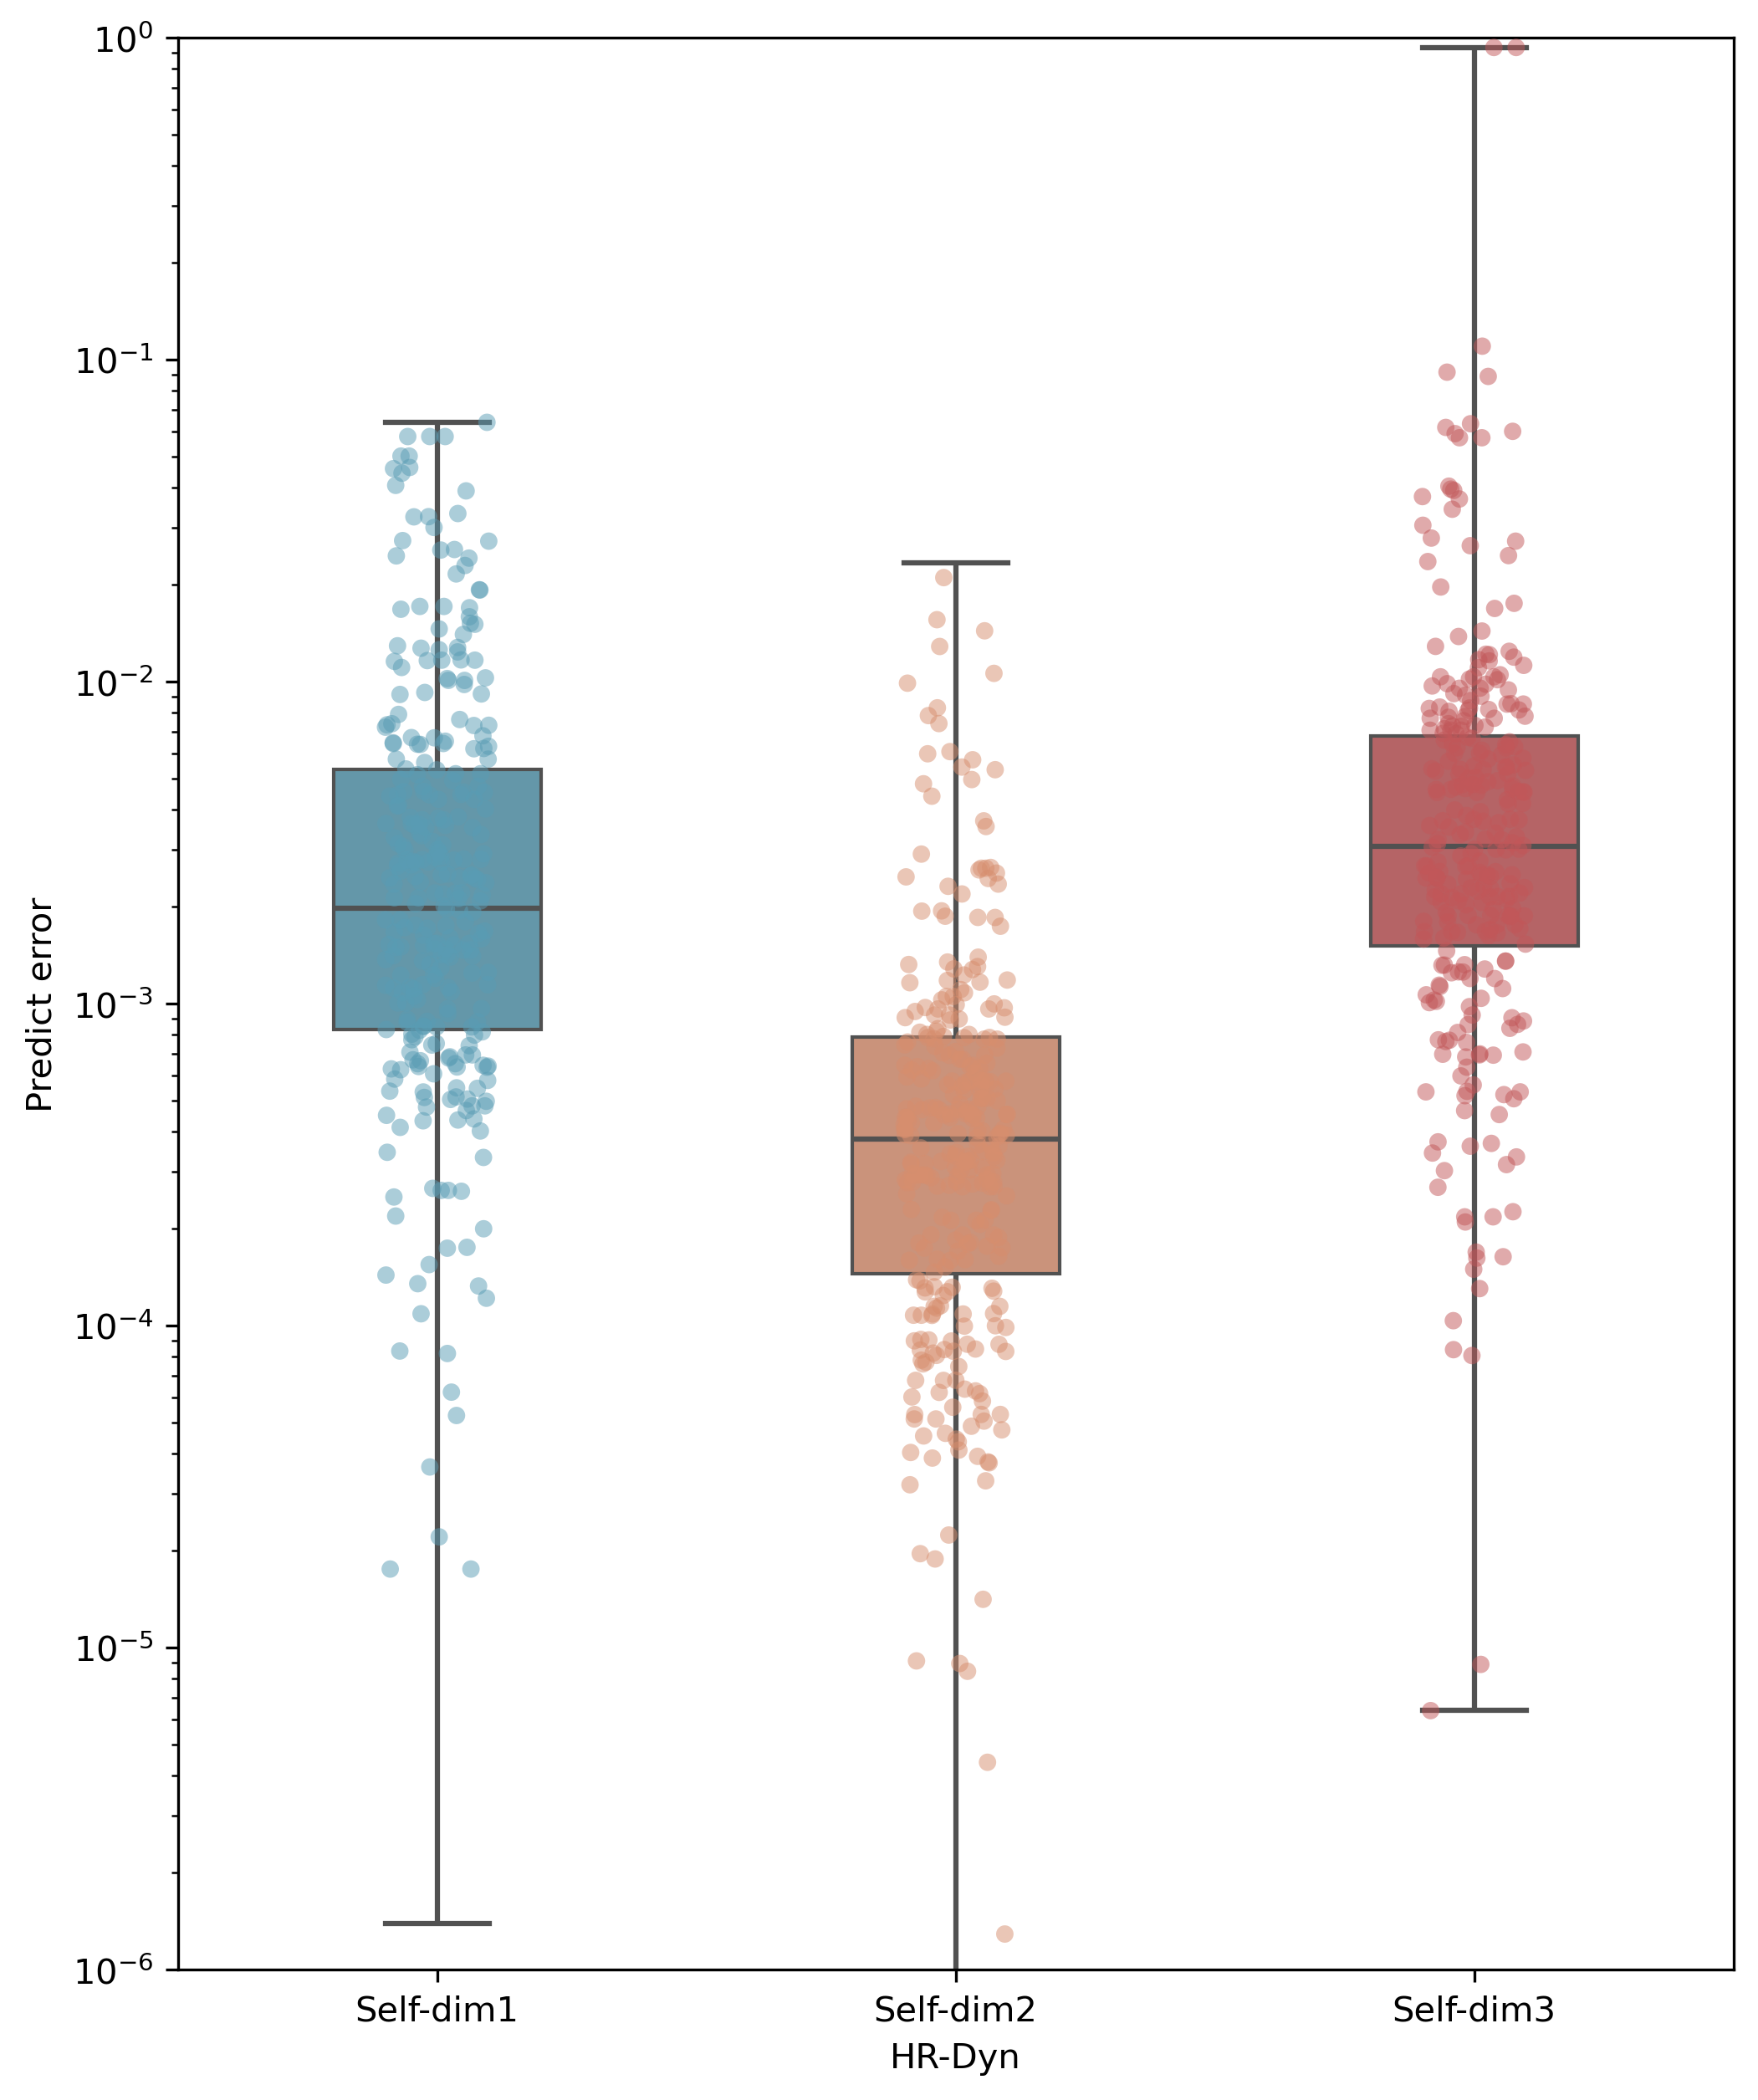

In [89]:
np.random.seed(2035)

sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])

index = np.random.randint(0, len(sx_true), 1000)

sx_true = sx_true[index]
sx = sx[index]
sy_true = sy_true[index]
sy = sy[index]
sz_true = sz_true[index]
sz = sz[index]

mx = max(np.abs(sx_true))
my = max(np.abs(sy_true))
mz = max(np.abs(sz_true))
print(mx,my,mz)

norm_errorx = np.abs((sx - sx_true)/mx)
norm_errory = np.abs((sy - sy_true)/my)
norm_errorz = np.abs((sz - sz_true)/mz)

error4self = pd.DataFrame()
errorselfall = np.hstack((norm_errorx,norm_errory,norm_errorz))
print(errorselfall.shape)
error4self['Predict error'] = errorselfall
error4self['HR-Dyn'] = ['Self-dim1']*int(len(index))+['Self-dim2']*int(len(index))+['Self-dim3']*int(len(index))
print(error4self.shape)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
f, ax = plt.subplots(figsize=(8, 10))

order = ['Self-dim1', 'Self-dim2', 'Self-dim3']
palette = ['#599CB4','#D78E6E','#C25759']
desamerror4self = error4self.sample(frac=0.3)
sns.stripplot(desamerror4self, x="HR-Dyn", y="Predict error", size=5,jitter=True, order=order, palette=palette,alpha=0.5)
sns.boxplot(x='HR-Dyn', y='Predict error', data=error4self,whis=[0, 100], width=.4, order=order, palette=palette,showfliers=False)
ax.set_ylim(1e-6, 1)
ax.set_yscale('log')
for line in ax.lines:  
    line.set_linewidth(1.5)  
# plt.savefig('figure2/v5/HR_self_prediction_error_boxplot.pdf')
plt.show()

## infer equation

In [90]:
best_selfDyn = selfdyn

In [91]:
import sys
from utils.Self_func import *
Dimension = 3
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 3, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
print(self_matrix.columns)

Index(['x1', 'x2', 'x3', 'x1x1', 'x1x2', 'x1x3', 'x2x2', 'x2x3', 'x3x3',
       'x1x1x1', 'x1x1x2', 'x1x1x3', 'x1x2x2', 'x1x2x3', 'x1x3x3', 'x2x2x2',
       'x2x2x3', 'x2x3x3', 'x3x3x3'],
      dtype='object')


2nd self dimension

In [92]:
goal = best_selfDyn['s2'].values
goal = pd.DataFrame(data = goal, columns =['s2'])
X = self_matrix.copy()
y = goal.copy()

In [93]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [94]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=5000).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9998520405810574
Best threshold: 0.001


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+01, tolerance: 8.613e+00
  model = cd_fast.enet_coordinate_descent(


In [95]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [96]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x1x1x2      1.000000e-10
x1x2x2      1.267411e-03
x2x2        3.865064e-03
x1x2x3     -7.129319e-03
x1         -4.116565e-02
x2x3       -4.464356e-02
x1x1x1     -5.873811e-02
x1x1x3     -1.745463e-01
x2         -8.267643e-01
x1x1       -4.348205e+00
constant    9.800020e-01
dtype: float64


In [97]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-1]].values.reshape(-1,1)
            X = pd.DataFrame(X,columns=[imp_cons.index[-1]])
        else:
            X = pd.concat([X,tmp],axis=1)
    else:
        Cons = np.ones((y1.shape[0],1))*imp_cons['constant']
        X = pd.DataFrame(Cons)
        X.columns = ['constant']
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])
    if Score>0.95:
        break

/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant   -0.0
dtype: float64
-0.0002057538891739874 2.1562491736770264 7685.702185752109 constant


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    1.243063
x1x1       -1.209083
dtype: float64
0.23881828802714722 1.6409598035979598 4956.813167427162 x1x1


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


constant    1.011177
x1x1       -4.992891
x2         -0.999962
dtype: float64
0.999708725738481 0.0006279306865329016 -73724.80769350383 x2


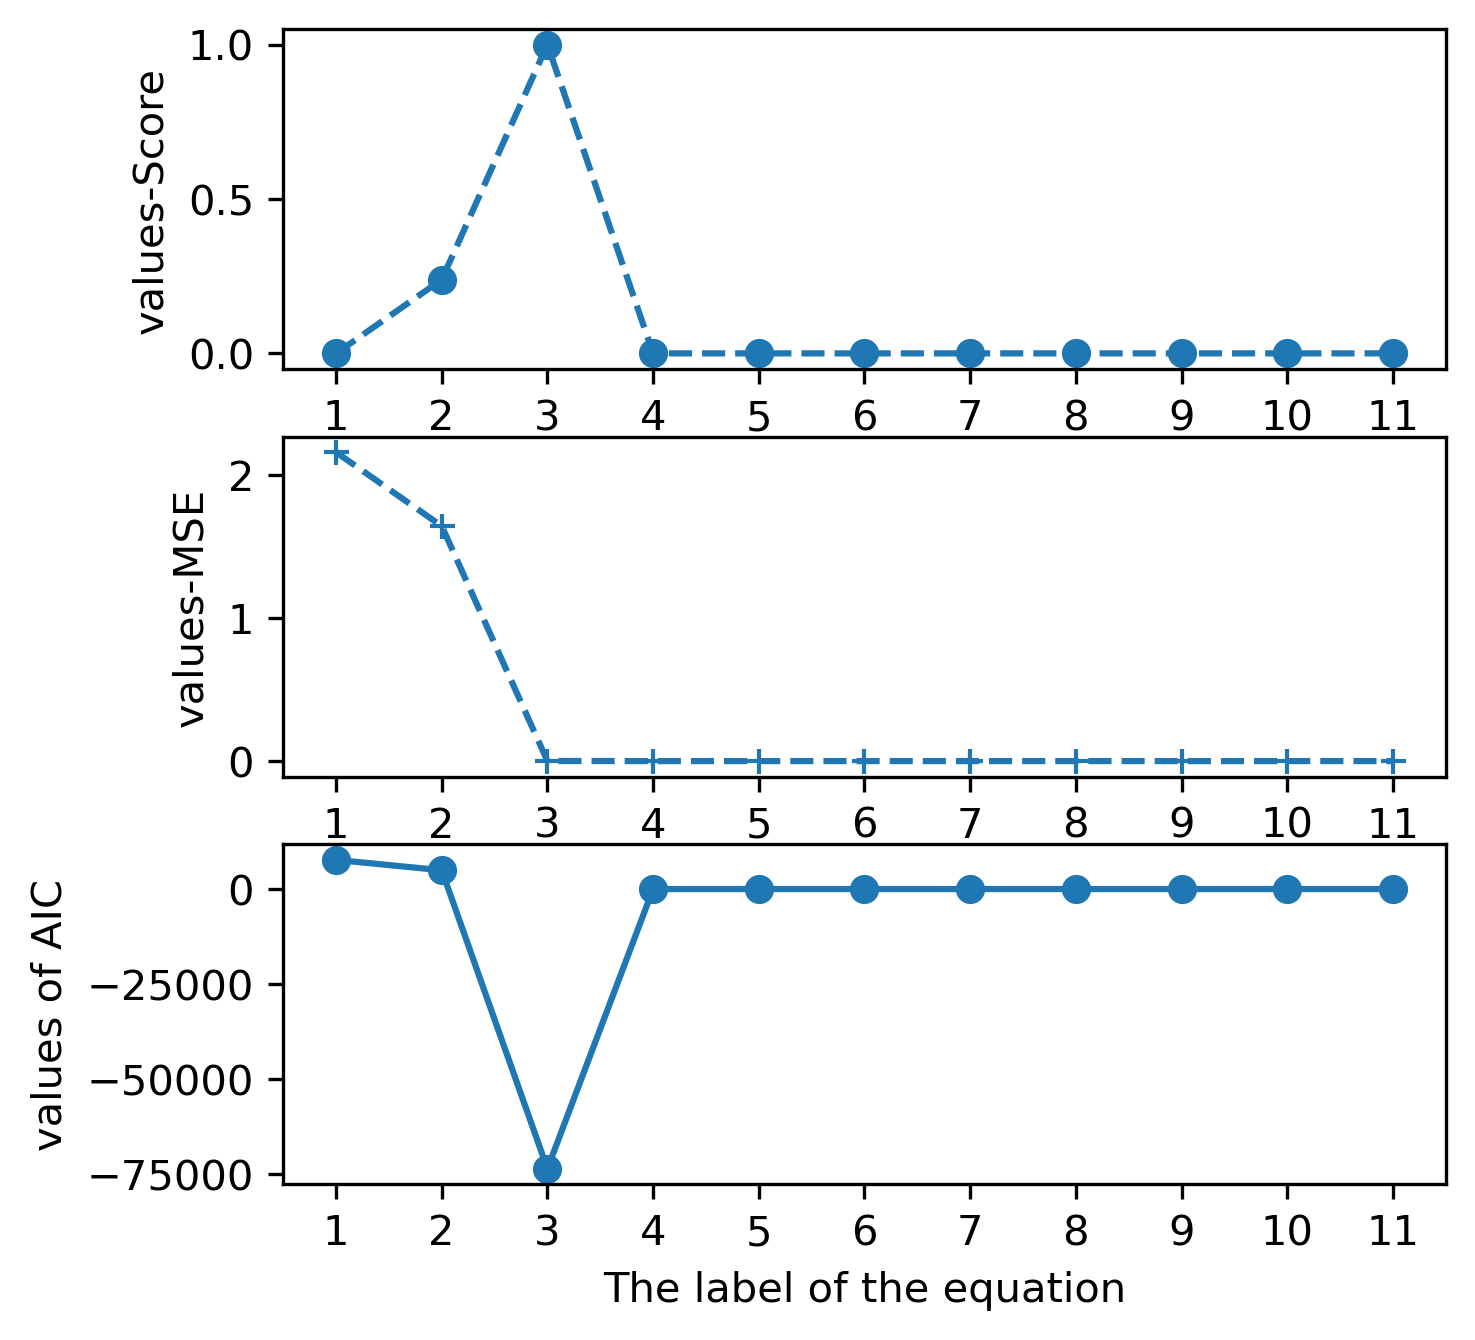

In [98]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
# plt.savefig('figure2/HR_selfdim2_equation_only_polynomial.pdf')
plt.show()

In [99]:
X = self_matrix.copy()
y = goal.copy()
Xfind = pd.concat([X['x2'],X['x1x1']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s2']

model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
b = model_linear.coef_
b1 = b.tolist()
print('constant:',model_linear.intercept_)
b1.append(model_linear.intercept_)
b1 = np.array(b1)
print(b1)

constant: 0.9943031904701223
[-1.00154151 -5.0020015   0.99430319]


In [100]:
# sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']

In [101]:
smape_dim2 = np.sum((np.abs(b1 - [-1,-5,1])) / (np.abs(b1 + [-1,-5,1])))/len(b1)
smape_dim2

0.0012756040122032057

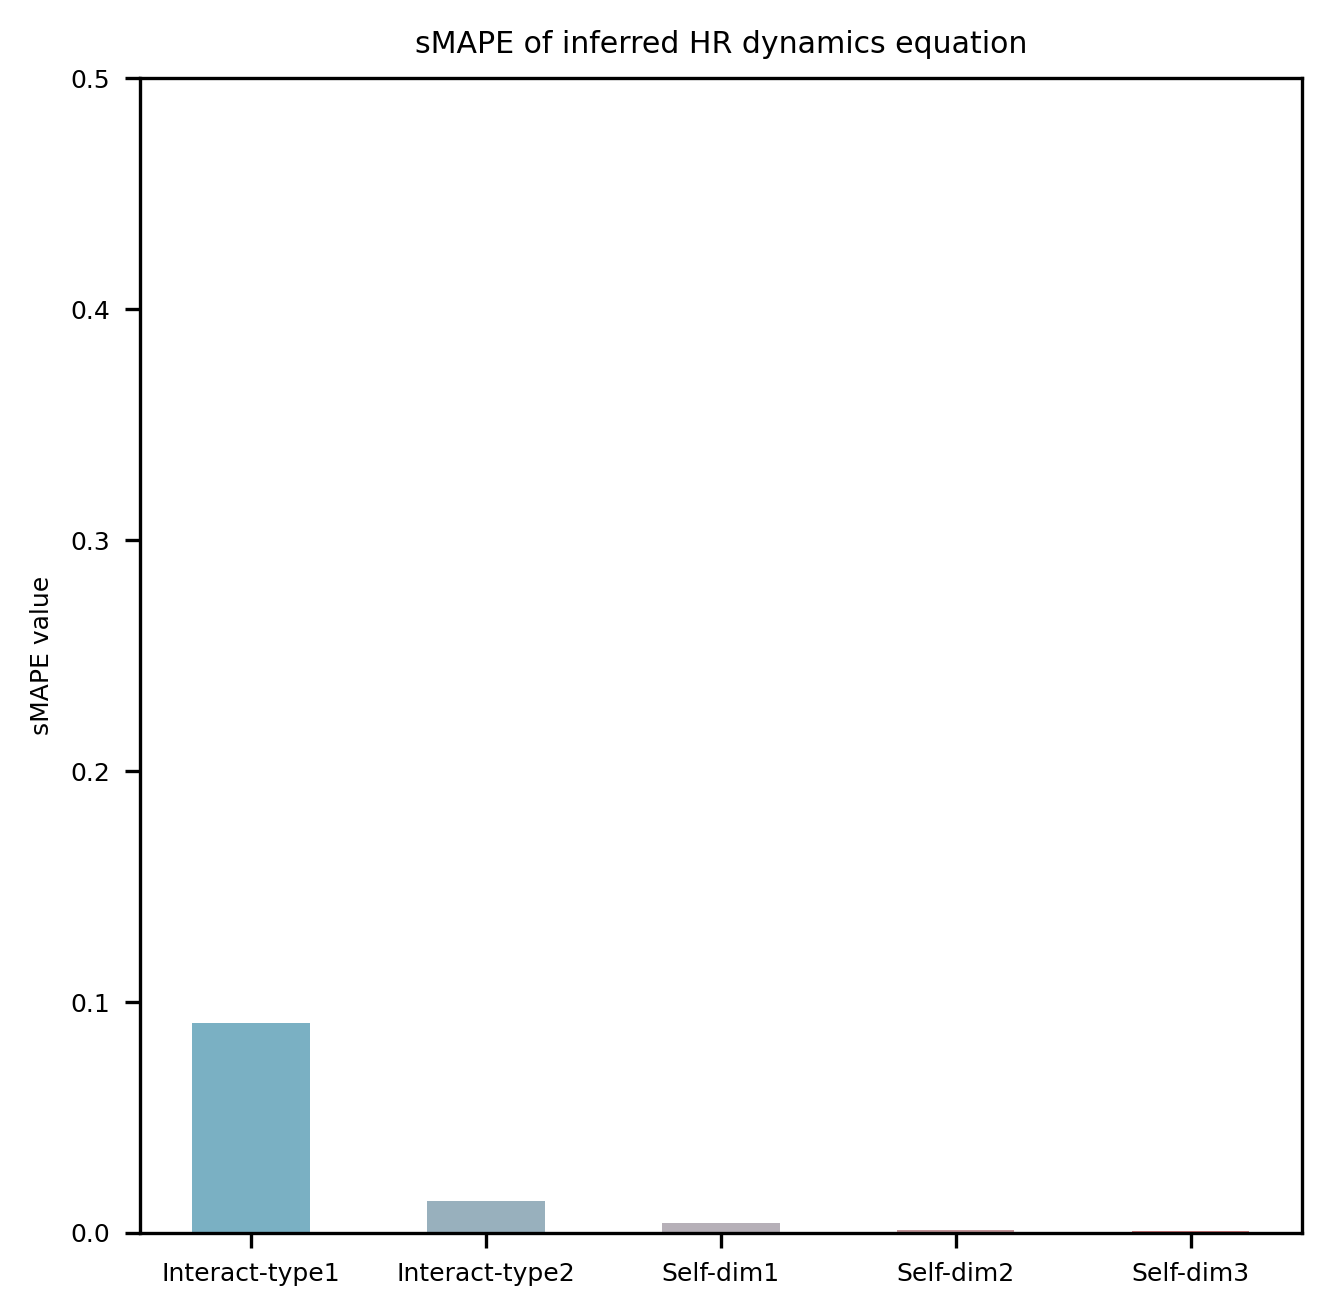

In [102]:
import matplotlib.pyplot as plt
import numpy as np  
from matplotlib.colors import LinearSegmentedColormap   

plt.rcParams.update({'font.size': 6})
values = np.load('inference_results_smape.npy')
labels = ['Interact-type1','Interact-type2', 'Self-dim1', 'Self-dim2', 'Self-dim3']

start_color = '#599CB4'  
end_color = '#C25759' 
mid_color = '#A49DA6'  
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [start_color, mid_color, end_color])
colors = custom_cmap(np.linspace(0, 1, len(labels)))
fig = plt.figure(figsize=(5,5))
plt.bar(labels, values, color=colors,width=0.5,alpha = 0.8)
# plt.semilogy()
plt.ylim(0,0.5)

plt.title('sMAPE of inferred HR dynamics equation')
plt.ylabel('sMAPE value')
# plt.savefig('figure2/v6/sMAPE_HR_equationinfer2_nolog.pdf')

plt.show()


## direct results from training process

In [103]:
path = data_path+'timeseries.pickle'
with open(path, 'rb') as f:
    objectAij, series= pickle.load(f)
with open(save_path+'weights_tau0.999_lam0.0001_20251013_191841.pkl', 'rb') as f:
    weights_over_epcs = pickle.load(f)

epc = 1999
weights_ind = weights_over_epcs[epc]
weights_ind = torch.Tensor(weights_ind)

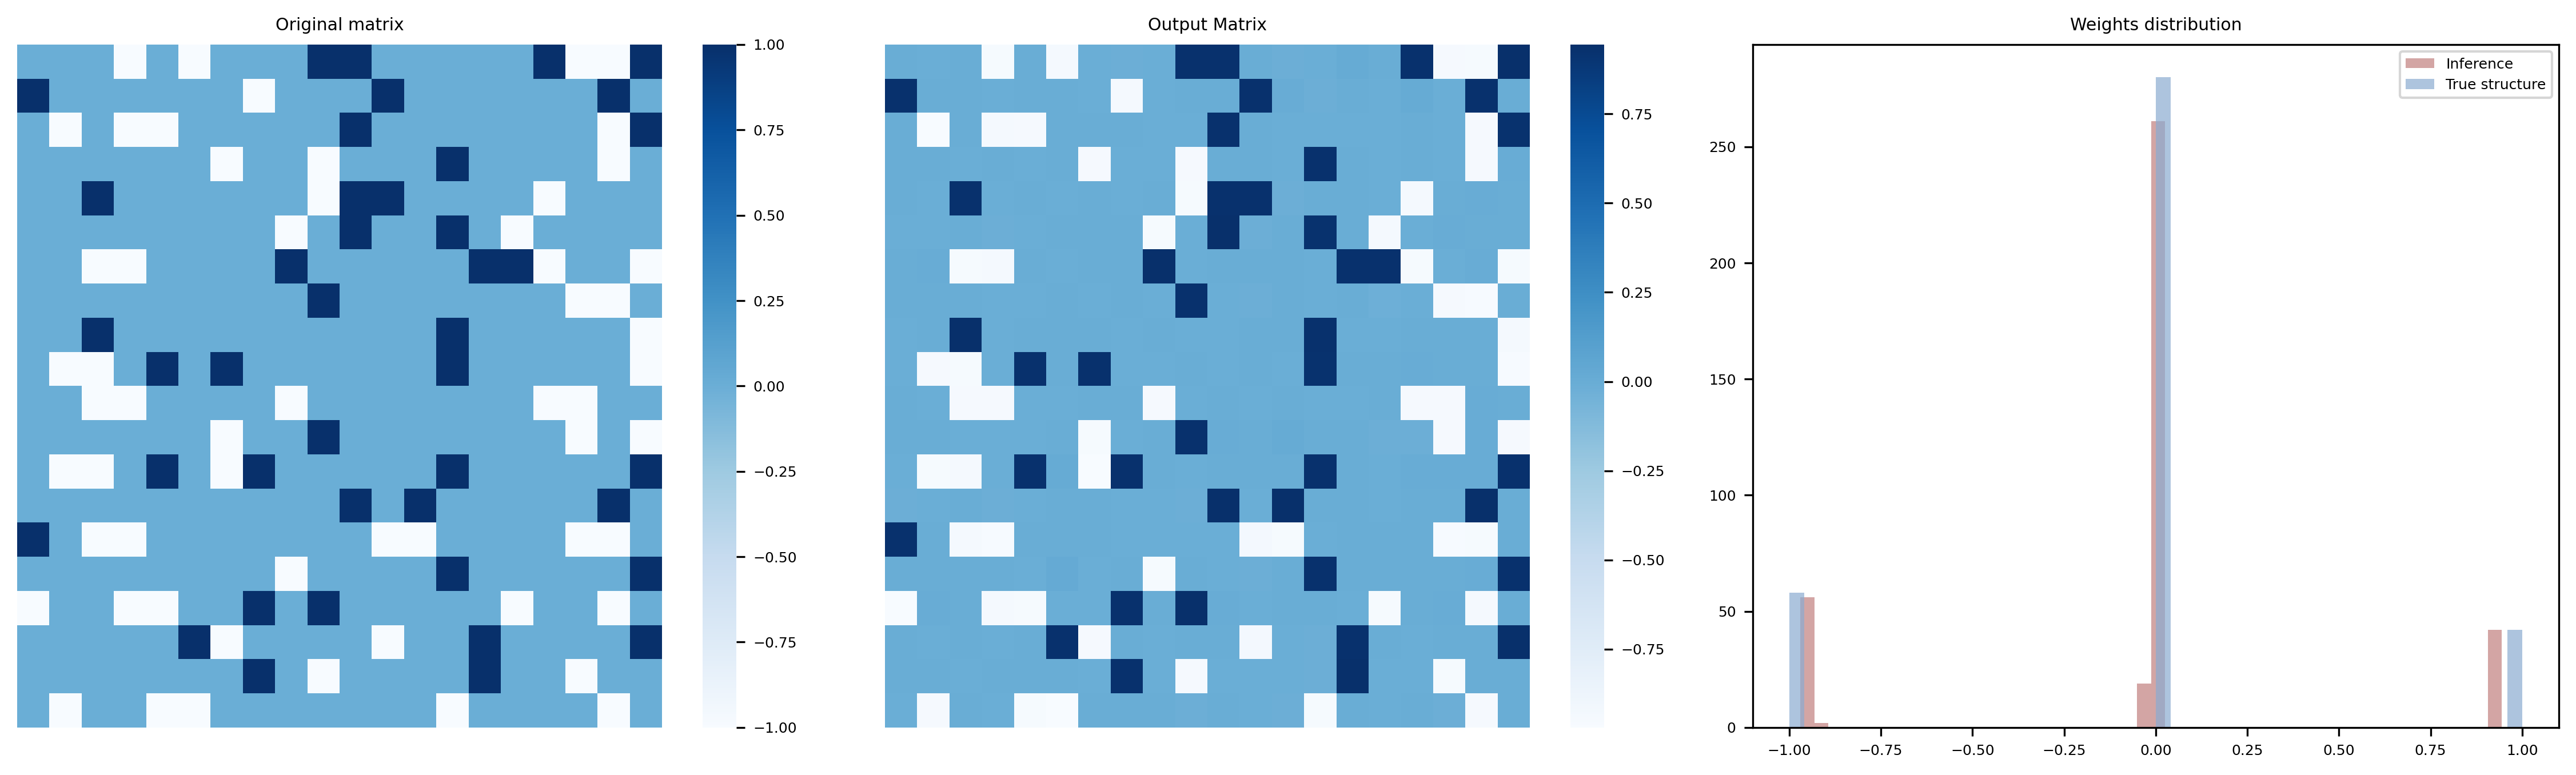

In [104]:
Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
Gweights = (1*Gweights[:,0])+((-1)*Gweights[:,1]) #Gweights[:,0] is excitatory, Gweights[:,1] is inhibitory
Gweights = Gweights.view(-1,1).cpu()
# Gweights.cpu
bestWei = Gweights.detach().numpy()

nodes_num = args.Nodes_num
edge_num = nodes_num*(nodes_num-1)
bestWei = bestWei[:edge_num]

Stru = np.zeros((nodes_num, nodes_num))
mask = np.ones((nodes_num, nodes_num), dtype=bool)
np.fill_diagonal(mask, 0)
Stru[mask] = bestWei.squeeze()

# Stru = Stru.T# the edges we learn is i to j, we want to show Aij(j to i).

Stru = -Stru
bestWei = -bestWei

selected_elements = objectAij[mask]
object_edges_rem_diag = selected_elements.reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
snb.heatmap(objectAij,cmap='Blues', ax=ax1)
ax1.set_title('Original matrix')
snb.heatmap(Stru, cmap='Blues', ax=ax2)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_title('Output Matrix')
plt.hist(bestWei,bins=50,alpha=0.7, color='#C17F7E', label='Inference')
plt.hist(object_edges_rem_diag,bins=50,alpha=0.7, color='#8BACD1', label='True structure')
plt.legend()
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_title('Weights distribution')

# plt.savefig('figure2/HR20nodes_inference_structure.pdf')

plt.tight_layout()
plt.show()

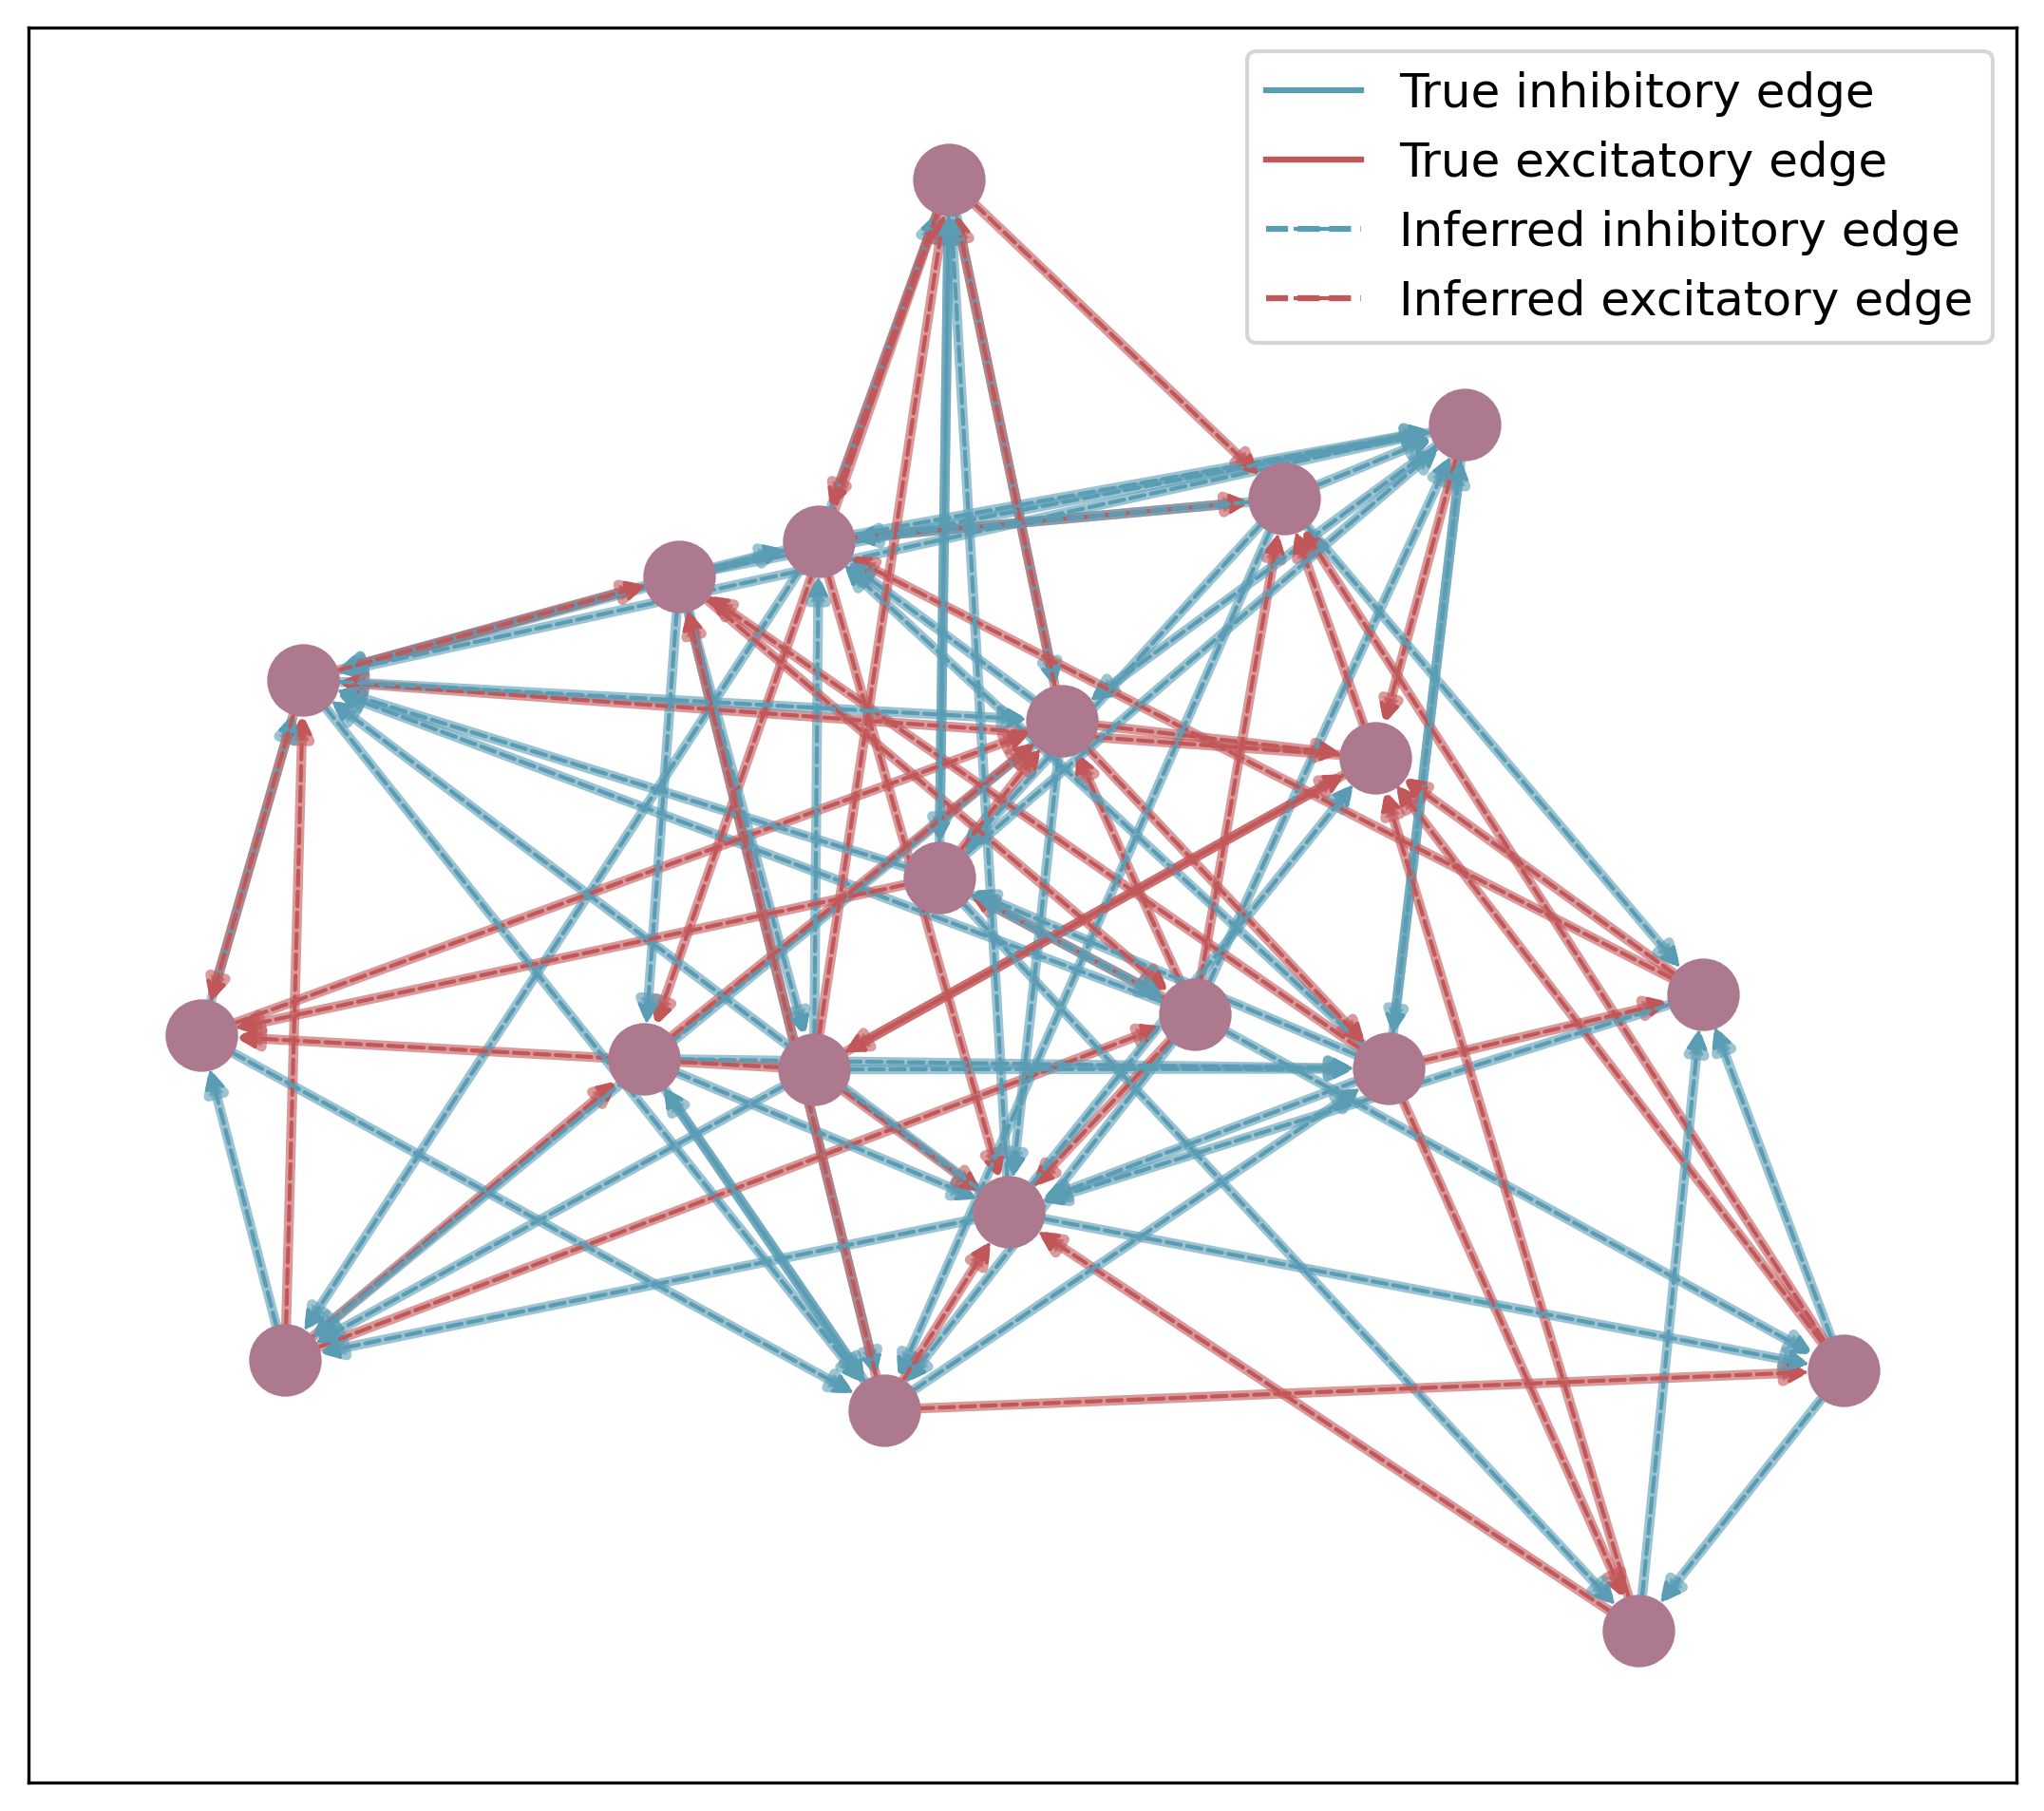

In [105]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

np.random.seed(2052)
plt.rcParams.update({'font.size': 12})  
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(9, 8))
G = nx.DiGraph()

palette = ['#C25759','#599CB4']
num_nodes = objectAij.shape[0]
G.add_nodes_from(range(num_nodes))

edge_colors = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if objectAij[i, j] == 1:
            G.add_edge(i, j)
            edge_colors.append('#C25759') # excitatory edges are red
        elif objectAij[i, j] == -1:
            G.add_edge(i, j)
            edge_colors.append('#599CB4') # inhibitroy edges are green

pos = nx.spring_layout(G) 
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_color='#AC798F', node_size=300)
# nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif')
nx.draw_networkx_edges(G, pos, width=2.5,edge_color=edge_colors,alpha=0.6,style='solid')

infer_edge_colors = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if objectAij[i, j] == 1:
            G.add_edge(i, j)
            infer_edge_colors.append('#C25759')  # excitatory edges are red
        elif objectAij[i, j] == -1:
            G.add_edge(i, j)
            infer_edge_colors.append('#599CB4')  # inhibitroy edges are green

nx.draw_networkx_edges(G, pos, width=1,edge_color=infer_edge_colors,alpha=1,style='dashed')

# create legend
true_inh = mlines.Line2D([], [], color='#599CB4', marker='_', markersize=15, label='True inhibitory edge', linestyle='solid')
true_exi = mlines.Line2D([], [], color='#C25759', marker='_', markersize=15, label='True excitatory edge', linestyle='solid')
infer_inh = mlines.Line2D([], [], color='#599CB4', marker='_', markersize=10, label='Inferred inhibitory edge', linestyle='dashed')
infer_exi = mlines.Line2D([], [], color='#C25759', marker='_', markersize=10, label='Inferred excitatory edge', linestyle='dashed')
plt.legend(handles=[true_inh, true_exi,infer_inh,infer_exi])
# plt.savefig('figure2/networkx_graph_20nodes.pdf')
plt.show()

(20, 20)


Text(0.5, 1.0, 'Structure inference error')

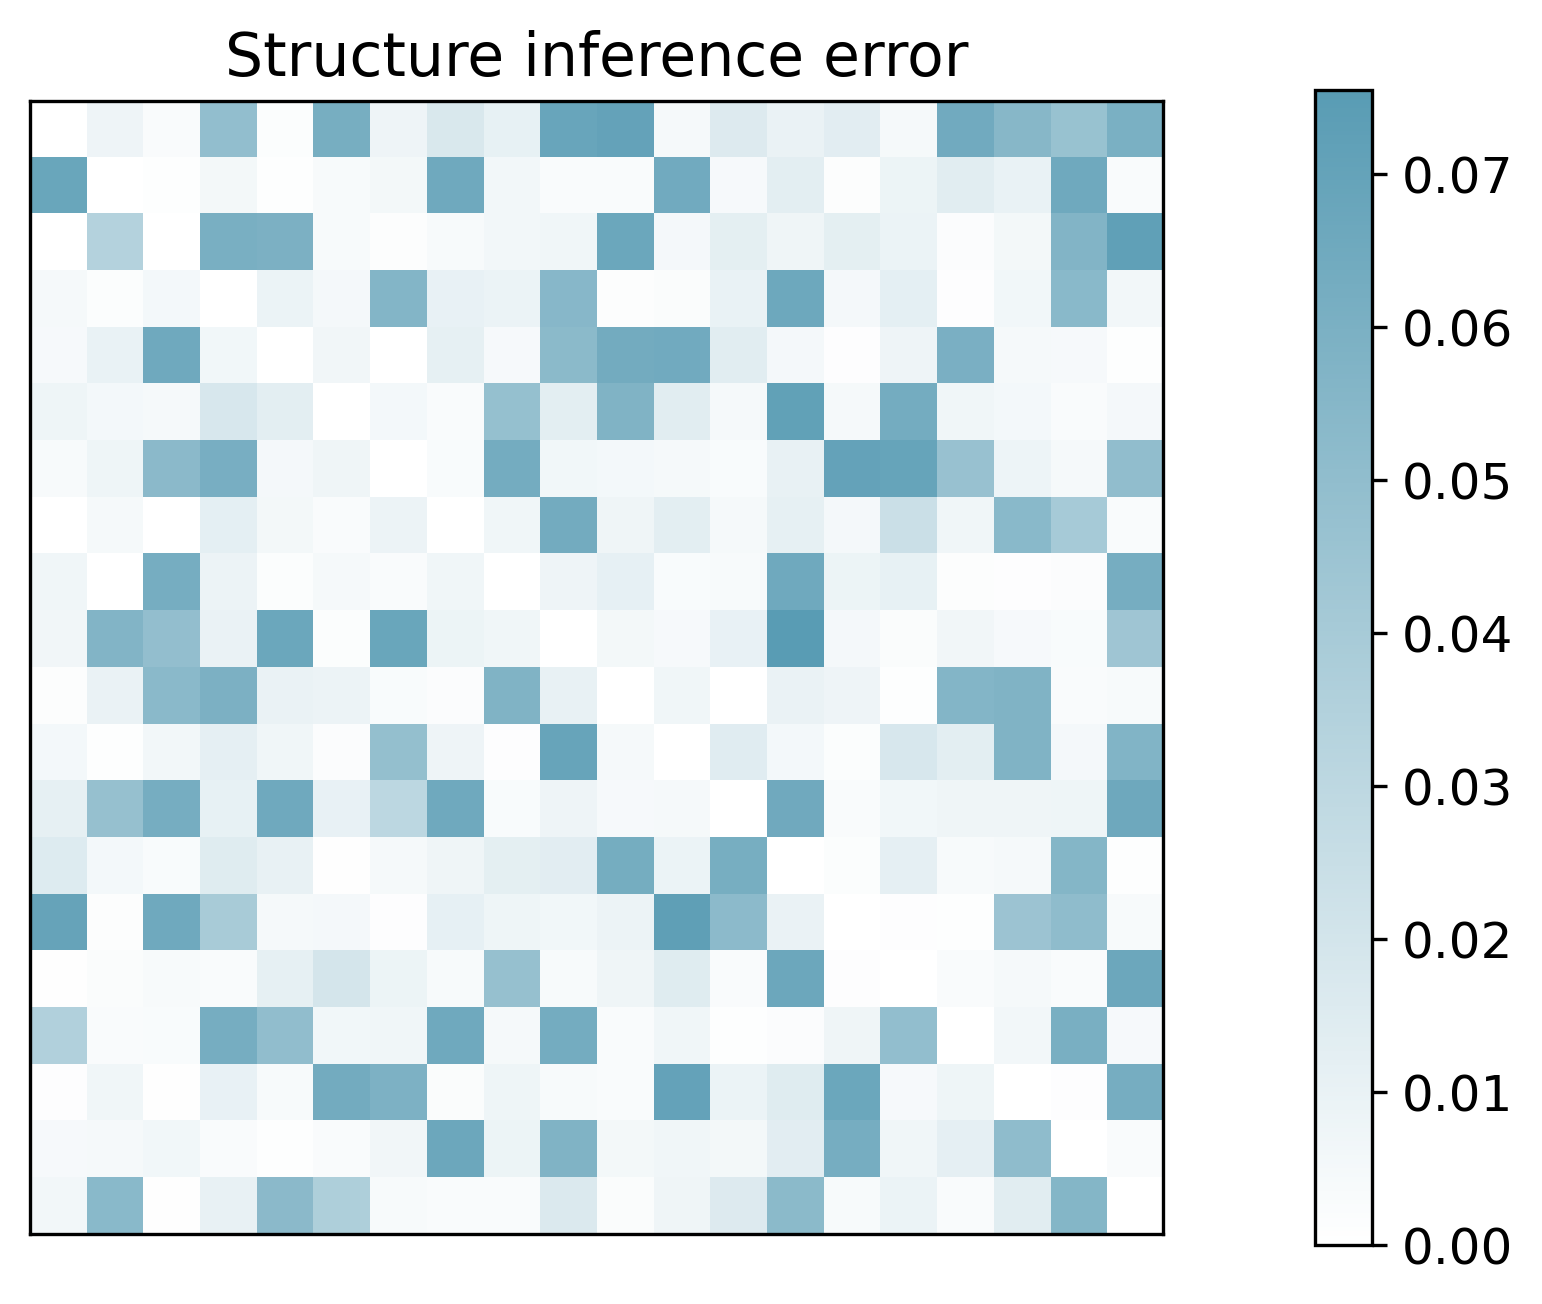

In [106]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 5))
struc_error = np.abs(objectAij-Stru)
# colors = ['#599CB4','#C25759'] 
colors = ['#ffffff','#599CB4'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
print(struc_error.shape)
im = plt.imshow(struc_error, cmap=cmap)
cbar = plt.colorbar(im,pad = 0.1)
plt.xticks([])
plt.yticks([])
plt.title('Structure inference error')
# plt.savefig('figure2/HR20nodes_inferror_green.pdf')

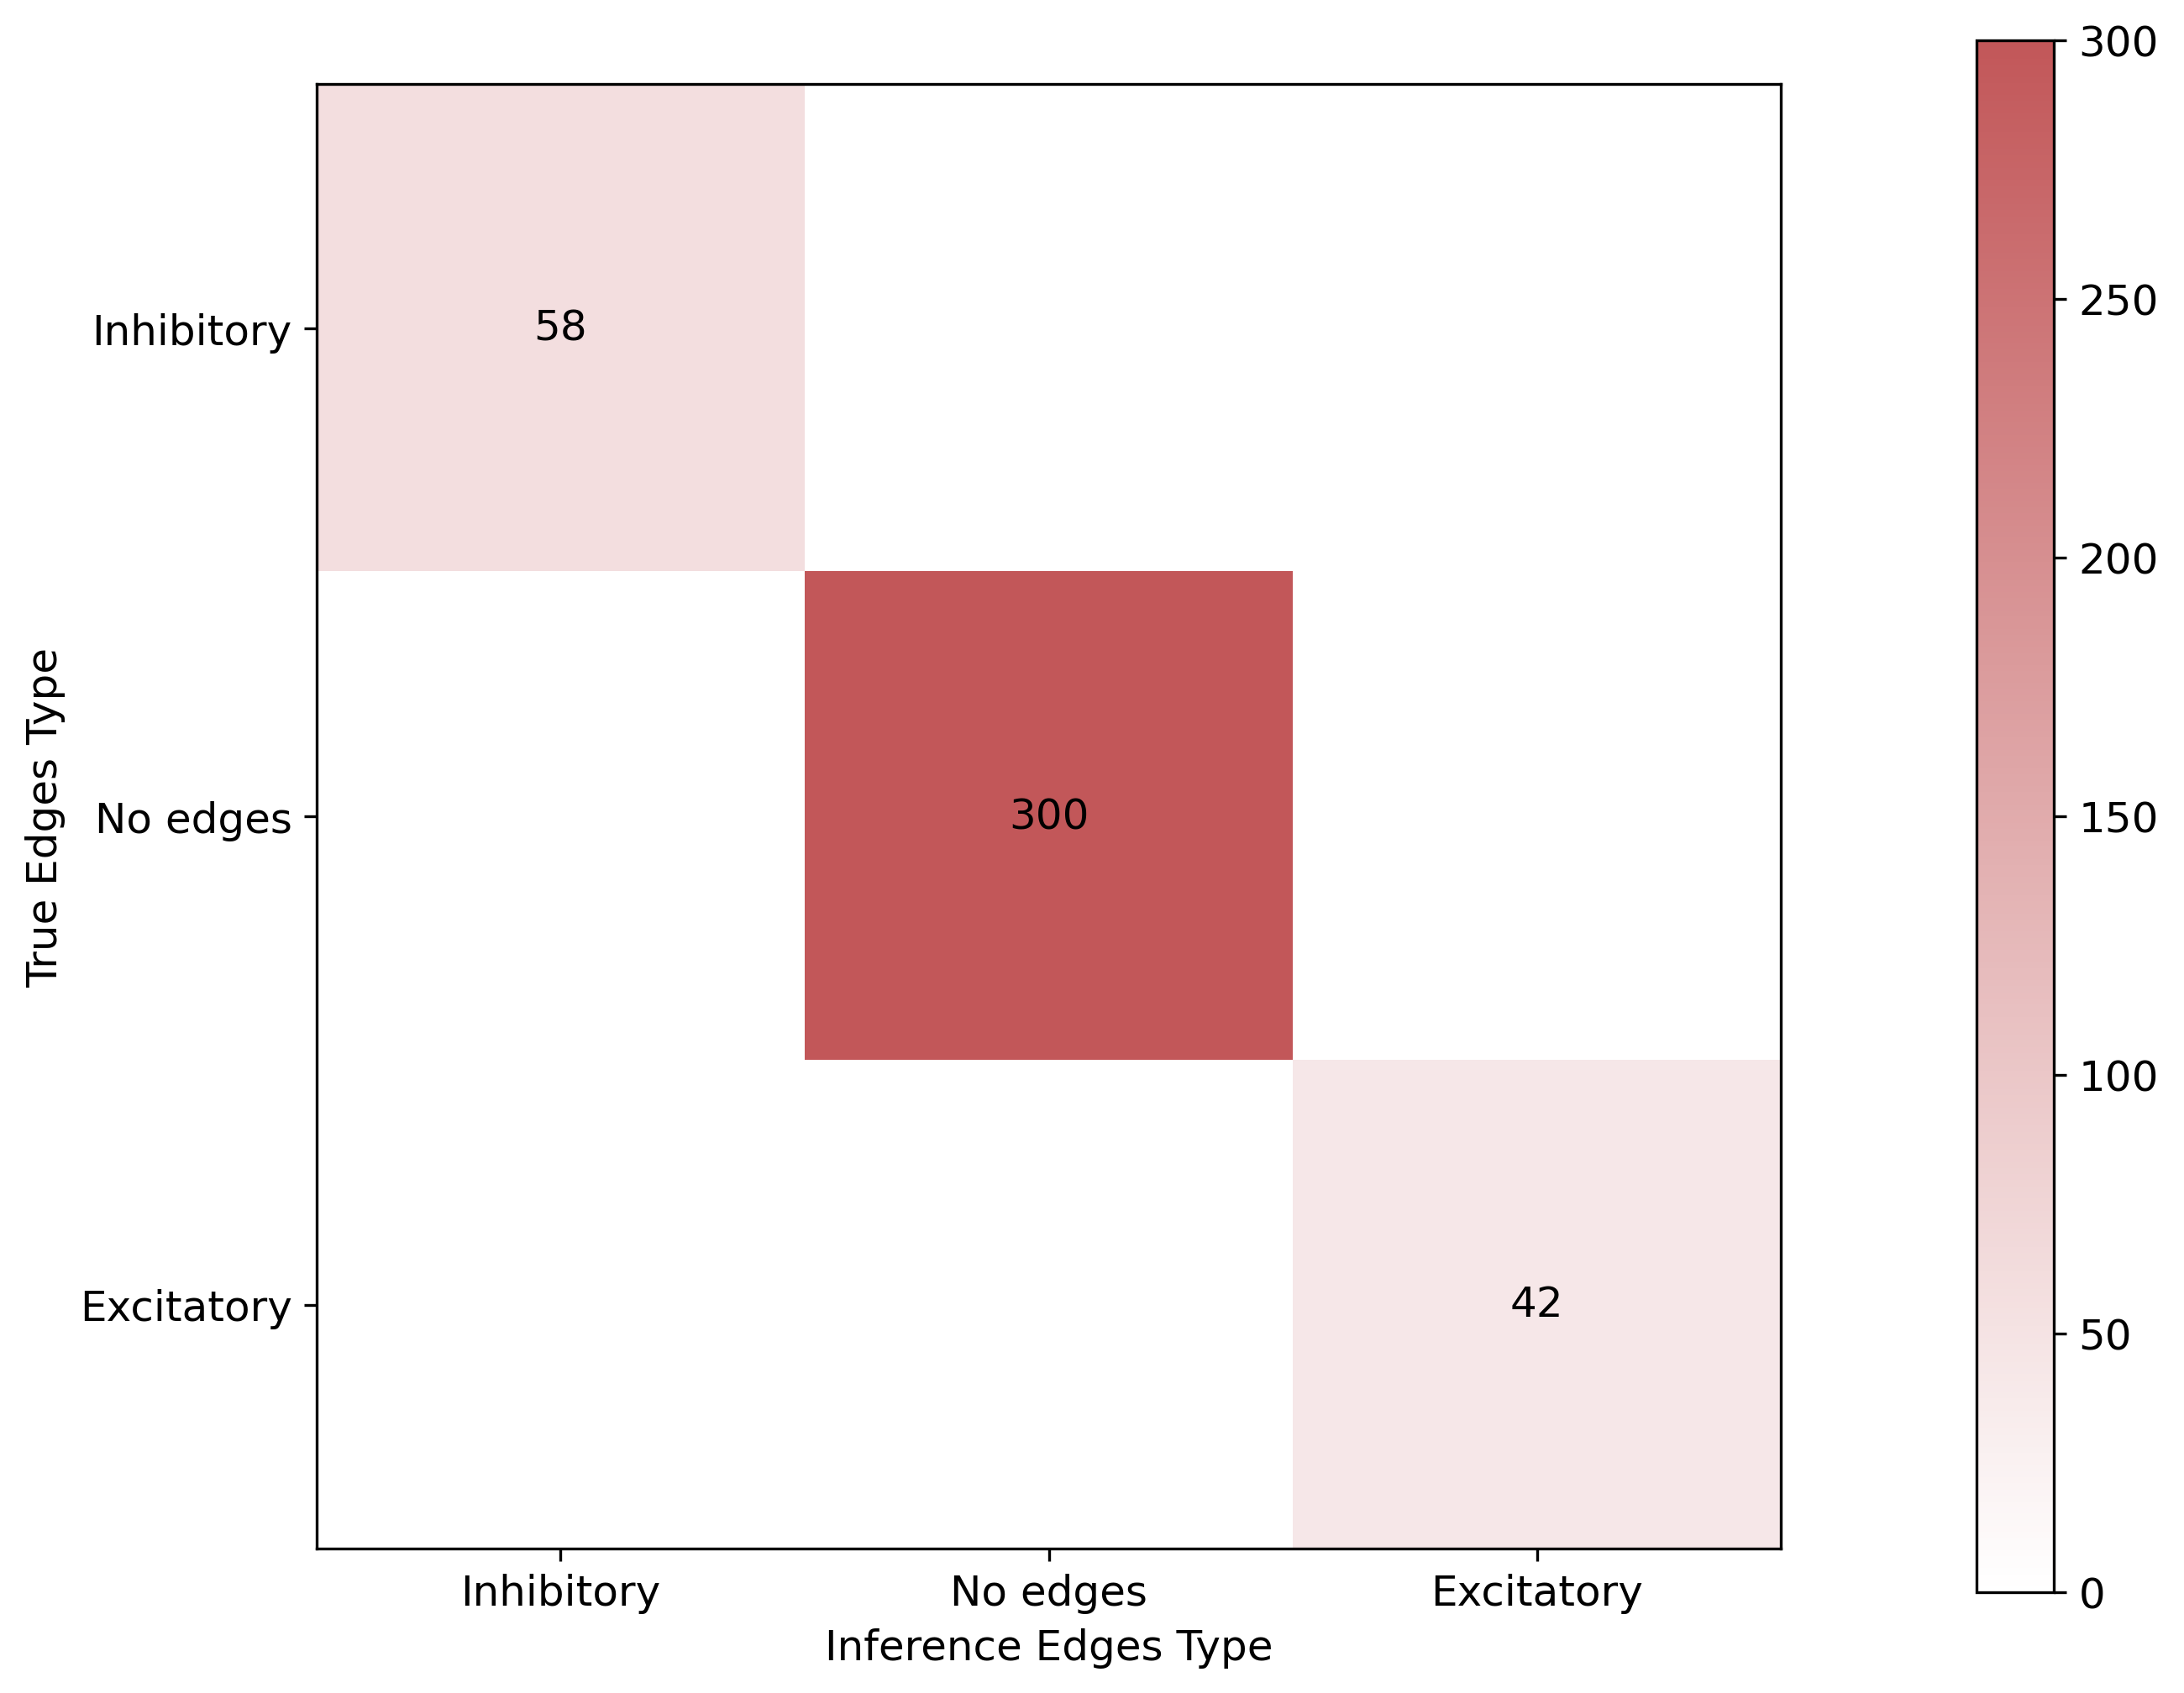

In [107]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ground_truth = objectAij.reshape(-1)
prediction = Stru.reshape(-1)

prediction_rounded = np.round(prediction)

cm = confusion_matrix(ground_truth, prediction_rounded)
colors = ['#ffffff','#C25759'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(10,8))
cfus = plt.imshow(cm, cmap=cmap)
cbar = plt.colorbar(cfus,pad = 0.1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i ==j :
            plt.text(j, i, f'{int(cm[i, j])}', ha='center', va='center', color='k')

plt.xticks([0., 1., 2.], ['Inhibitory','No edges','Excitatory'])
plt.yticks([0., 1., 2.], ['Inhibitory','No edges','Excitatory'])
plt.xlabel('Inference Edges Type')
plt.ylabel('True Edges Type') 
# plt.savefig('figure2/HR20nodes_confusion.pdf')
plt.show()


In this confusion matrix, the rows represent the actual edge categories, and the columns represent the inferred edge categories. The value in each cell indicates the number of times the corresponding actual edge type was inderred as the corresponding predicted edge type. Cells on the diagonal represent correct predictions, while cells off the diagonal represent incorrect predictions.